# Delivery Time Estimation

---

#### Problem

Logistic company is trying to estimate the delivery time of the order, based on different variables:-
- What they are ordering?
- From Where they are ordering
- The availability of Delivery Partners

Alternative to Logistics, similar approach can be used in
- Cab Services
- Supply Chain Management
- E-Commerce

> I'll explore the data to find hidden stories and since this is a Regression task, I'll use Neural Networks to estimate the same.

# Data Initialization

We are going to use Spark session to initialize our data frame

In [1]:
# Importing required libraries
from pyspark.sql import SparkSession

In [2]:
# Filtering Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Initializing Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
# Adjust Spark session settings to improve display
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 50)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
# Investigating Dataset
df = spark.read.csv('../data/raw/data.csv', header=True, inferSchema=True)
display(df.limit(5))

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NULL,1.0,6,6900,5,600,1800,1.0,1.0,2.0
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NULL,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [6]:
# Shape of the dataset
print(f"Shape of DataFrame: (rows: {df.count()}, columns: {len(df.columns)})")

Shape of DataFrame: (rows: 197428, columns: 14)


**Observation**
- We have 14 features and almost 200K datapoints.
- Data seems to be of descent small size.

In [7]:
# Datatypes Info
df.printSchema()

root
 |-- market_id: double (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- actual_delivery_time: timestamp (nullable = true)
 |-- store_id: string (nullable = true)
 |-- store_primary_category: string (nullable = true)
 |-- order_protocol: double (nullable = true)
 |-- total_items: integer (nullable = true)
 |-- subtotal: integer (nullable = true)
 |-- num_distinct_items: integer (nullable = true)
 |-- min_item_price: integer (nullable = true)
 |-- max_item_price: integer (nullable = true)
 |-- total_onshift_partners: double (nullable = true)
 |-- total_busy_partners: double (nullable = true)
 |-- total_outstanding_orders: double (nullable = true)



**Date/Timestamp Type Handling**

Since spark can automatically sense the schema, pandas on the other hand might fail for same. In pandas, we might need to use
- `pd.to_datetime()`: To convert string to datetime type.
- `datetime.strftime()`: To format datetime in correct order.
- `datetime.dt.hour`: To extract hour from our datetime column for feature engineering.

In [8]:
# Filtering columns on the basis of Data Types
from pyspark.sql.types import StringType, NumericType, TimestampType
continuous_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
temporal_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, TimestampType)]

In [9]:
# Checking NaN Values 
from pyspark.sql.functions import col, count, when
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas().transpose()/df.count() * 100

,0
market_id,0.499929
created_at,0.000000
actual_delivery_time,0.003546
store_id,0.000000
store_primary_category,2.411006
order_protocol,0.503981
total_items,0.000000
subtotal,0.000000
num_distinct_items,0.000000
min_item_price,0.000000


**Observation**
- Need to treat many Null Values, Cannot drop.

In [10]:
# Statistics Summary
df.select(*continuous_cols).summary().toPandas().transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
market_id,196441,2.978706074597462,1.5248667244506318,1.0,2.0,3.0,4.0,6.0
order_protocol,196433,2.8823517433425137,1.5037712034995814,1.0,1.0,3.0,4.0,7.0
total_items,197428,3.196390582896043,2.666546063599881,1,2,3,4,411
subtotal,197428,2682.331401827502,1823.0936878547877,0,1400,2200,3395,27100
num_distinct_items,197428,2.6707913771096297,1.6302552413381575,1,1,2,3,20
min_item_price,197428,686.2184695180015,522.0386476914739,-86,299,595,949,14700
max_item_price,197428,1159.5886297789573,558.4113766592682,0,800,1095,1395,14700
total_onshift_partners,181166,44.808093130057514,34.5267834762135,-4.0,17.0,37.0,65.0,171.0
total_busy_partners,181166,41.739746972389966,32.14573271803179,-5.0,15.0,34.0,62.0,154.0


**Observation**
- Higher Outliers observed in Subtotals, indicating the field is affected by extremes.
- Thorough investigation is required for the Negative values observed in the Item price, orders and partners.

In [11]:
# Unique Values Observed
from pyspark.sql.functions import countDistinct
df.agg(*(countDistinct(c).alias(c) for c in df.columns)).toPandas().transpose()

,0
market_id,6
created_at,180985
actual_delivery_time,178110
store_id,6743
store_primary_category,74
order_protocol,7
total_items,57
subtotal,8368
num_distinct_items,20
min_item_price,2312


In [12]:
# Analyze Value counts for Low Cardinal features
from pyspark.sql.functions import lit,col,round
low_cardinal = ["market_id", "order_protocol"]
for c in low_cardinal:
    display(df.groupby(c).count().withColumn( "normalized_count", round(col("count")/lit(df.count()) * 100,2) ))

market_id,count,normalized_count
NULL,987,0.5
1.0,38037,19.27
4.0,47599,24.11
3.0,23297,11.8
2.0,55058,27.89
6.0,14450,7.32
5.0,18000,9.12


order_protocol,count,normalized_count
7.0,19,0.01
NULL,995,0.5
1.0,54725,27.72
4.0,19354,9.8
3.0,53199,26.95
2.0,24052,12.18
6.0,794,0.4
5.0,44290,22.43


**Observation**
- marked_id of 2 dominates the market.
- order_protocol 1 & 3 , most common protocols used to place order.

In [13]:
# Duplicate Records
df.exceptAll(df.dropDuplicates()).count()

0

# Exploratory Data Analysis

In [14]:
# Assigning Discrete Numerical Cols to Categorical cols
discrete_cols = [ "market_id","order_protocol","num_distinct_items"]
for c in discrete_cols:
    continuous_cols.remove(c)
    categorical_cols.append(c)

In [15]:
# Initializing Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set_style('darkgrid')

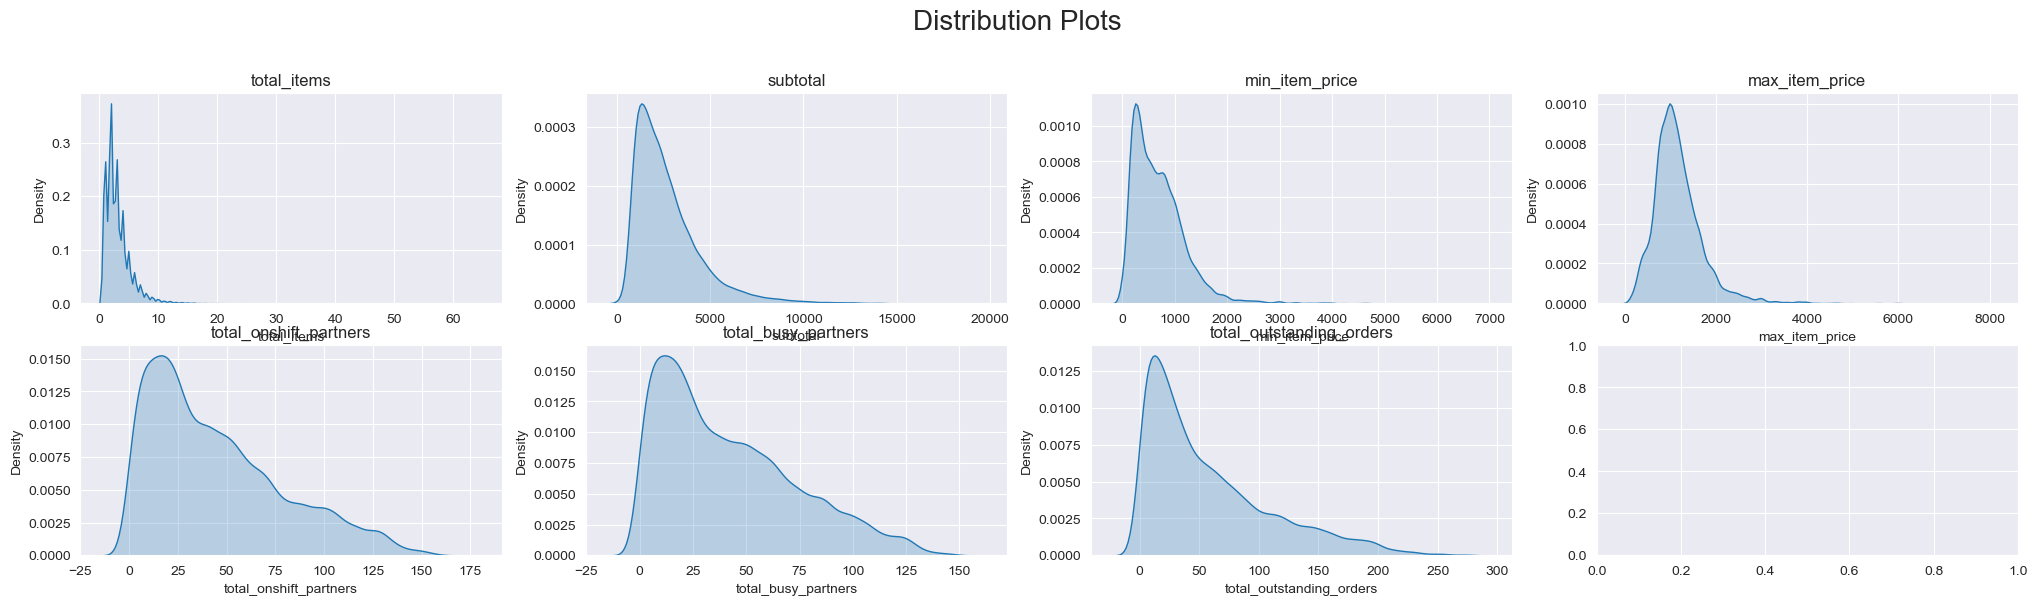

In [16]:
pandas_df = df.dropna().sample(False,fraction = 0.25,seed=42).toPandas()
nrows = (len(continuous_cols) // 4) + (len(continuous_cols) % 2)

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(25, 3 * nrows))
axes = axes.flatten()       # Flattening for easy indexing

for i, feature in enumerate(continuous_cols):
    sns.kdeplot(data=pandas_df, x=feature, fill=True, ax=axes[i] )
    axes[i].set_title(feature)

plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observation**
- All the distribution seems to be a part od **Log Normal** Distribution (We need to handle negative values since Log Normal can never have value less than 0 or 0).
- `total_items` is highly skewed indicating large presence of outliers.

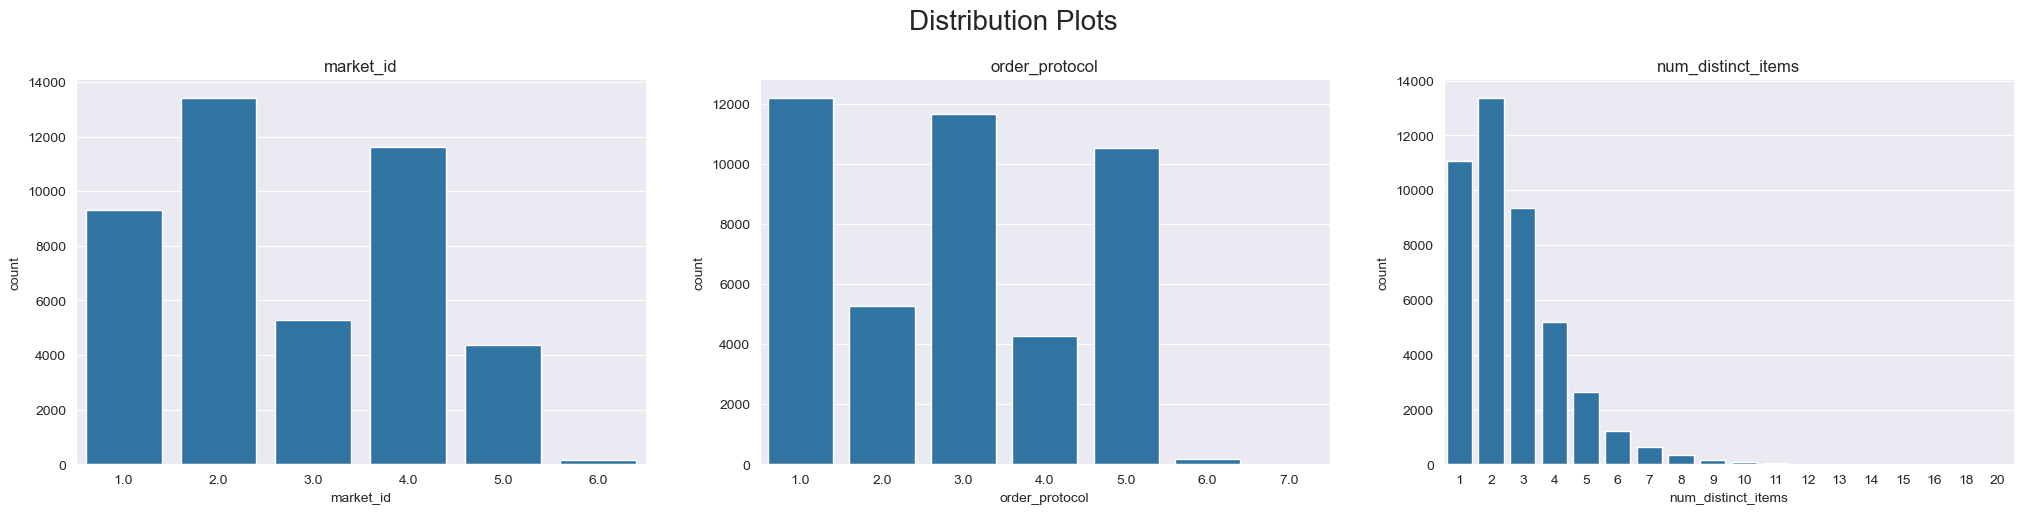

In [17]:
# Analyzing Categorical Columns
counter = 0
fig, axes = plt.subplots(ncols=3, figsize=(25, 5))
axes = axes.flatten()

for i, feature in enumerate(categorical_cols):
    if feature == 'store_id' or feature == 'store_primary_category': 
        counter += 1
        continue
    sns.countplot(data=pandas_df, x=feature, ax=axes[i-counter] )
    axes[i-counter].set_title(feature)
    
plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observation**
- Customers prefer to at least order two distinct items.

**Date Time Operations for ETA**

In pandas, we might need to extract minutes
- `datetime`: represents data and time with desired granularity.
- `timedelta`: represents difference between dates and times
- `time span`: represents duration between two point in time.

Using Pyspark, we can cast the difference as long and divide by 60, to get the result in minutes.

In [18]:
# Creating target variable for further analysis
from pyspark.sql.functions import col,round
df = df.withColumn("eta", round((col("actual_delivery_time").cast("long") - col("created_at").cast("long"))/60))
df.limit(3)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0


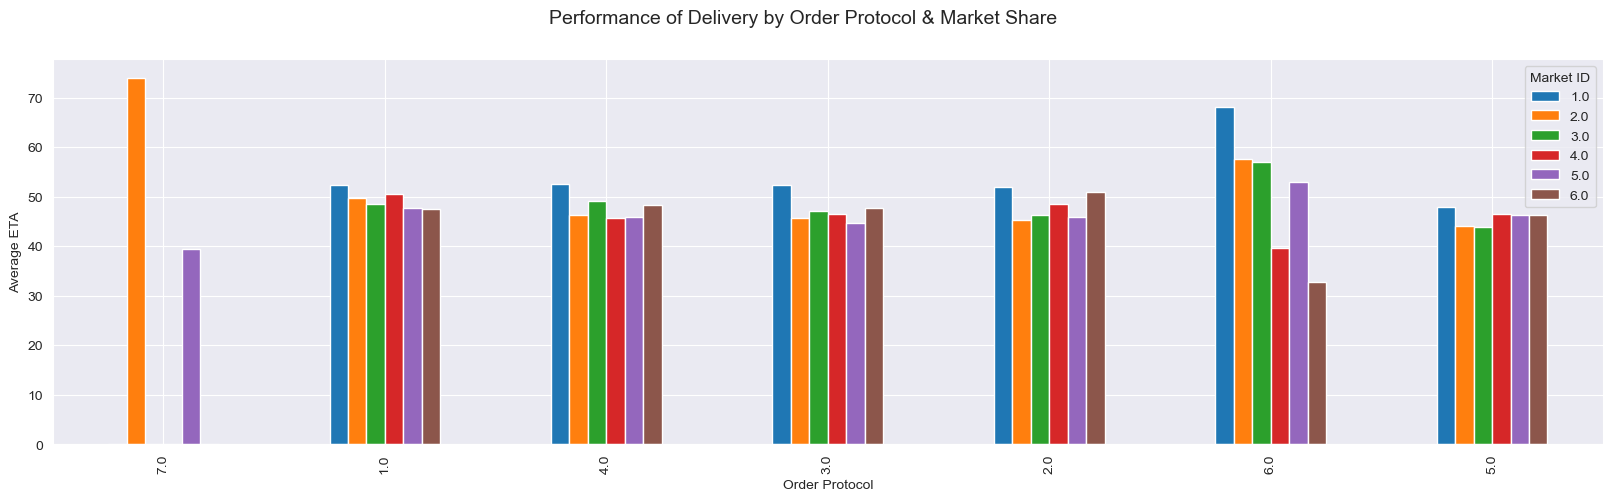

In [19]:
# ----Does the performance of delivery depends on order_protocol and market_id?----
from pyspark.sql.functions import avg

pandas_df = df.dropna()
grouped_df = pandas_df.groupby("order_protocol", "market_id").agg(avg("eta").alias("avg_eta"))
pivot_df = grouped_df.groupby("order_protocol").pivot("market_id").avg("avg_eta").fillna(0).toPandas().set_index("order_protocol")

pivot_df.plot(kind = "bar", stacked=False, figsize = (20,5))
plt.suptitle("Performance of Delivery by Order Protocol & Market Share", fontsize=14)
plt.xlabel('Order Protocol')
plt.ylabel('Average ETA')
plt.legend(title='Market ID')
plt.show()

**Observation**
- In Order Protocol 7, Not all market_id participates and order from market_id 2 takes most time to deliver.
- Order Protocol 6 is delivered fastest from market_id 6 and slowest from market_id 1

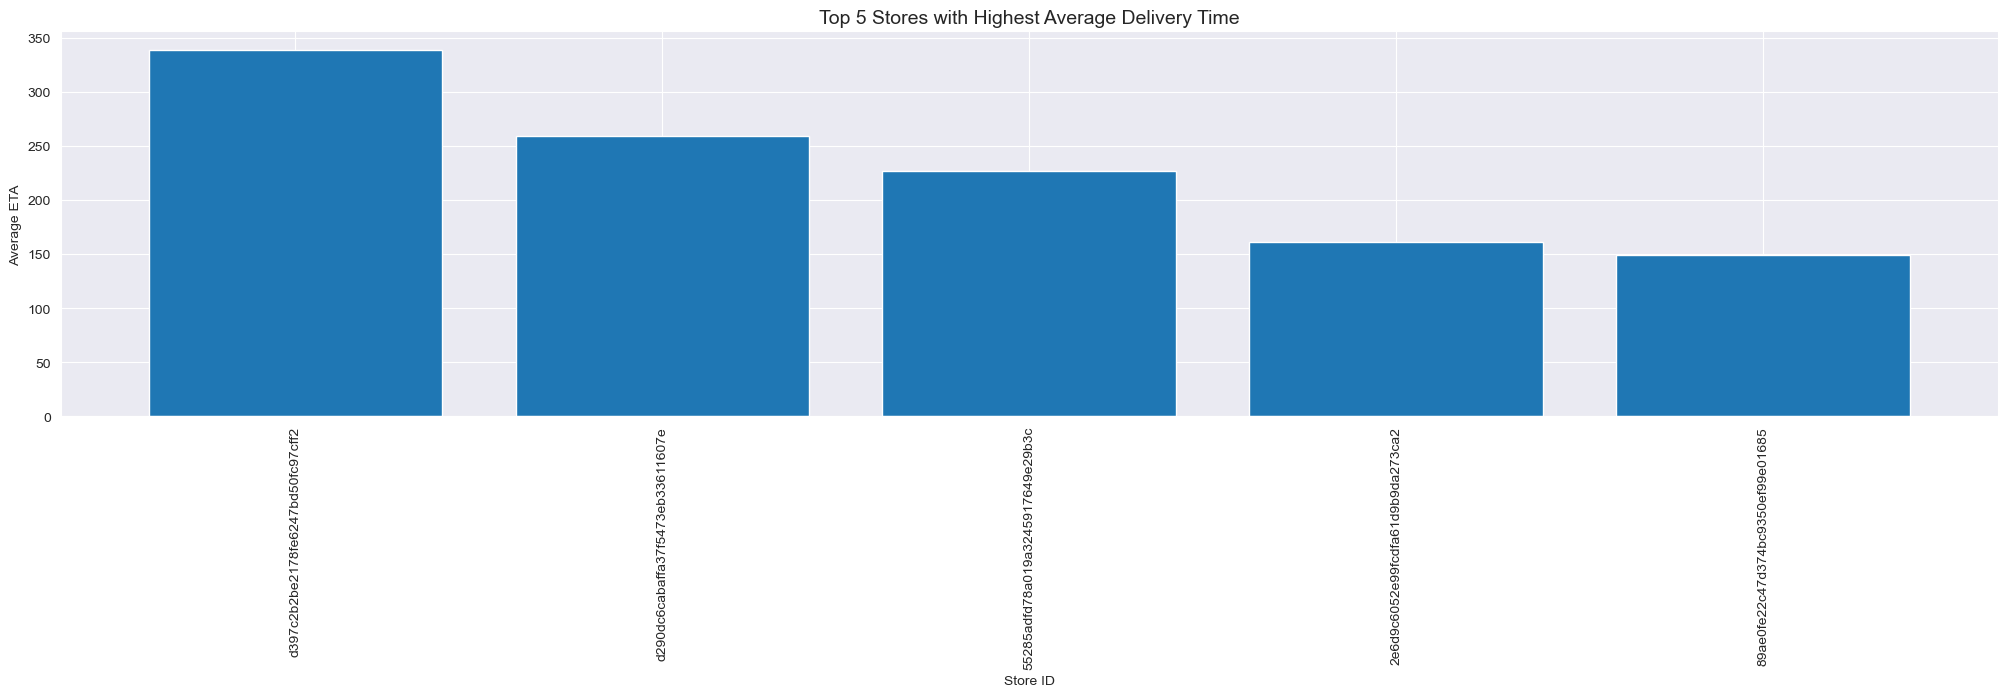

In [20]:
from pyspark.sql.functions import avg

pandas_df = df.dropna()
grouped_df = pandas_df.groupBy("store_id").agg(avg("eta").alias("avg_eta"))
pandas_df = grouped_df.toPandas()
top_5_stores = pandas_df.sort_values(by='avg_eta', ascending=False).head(5)

plt.figure(figsize=(25, 5))
plt.bar(top_5_stores['store_id'], top_5_stores['avg_eta'])
plt.title("Top 5 Stores with Highest Average Delivery Time", fontsize=14)
plt.xlabel('Store ID')
plt.ylabel('Average ETA')
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary for better readability
plt.show()

**Observation**

- A very high `eta` of 300 minutes is observed for some stores.
- Needs further inspection.

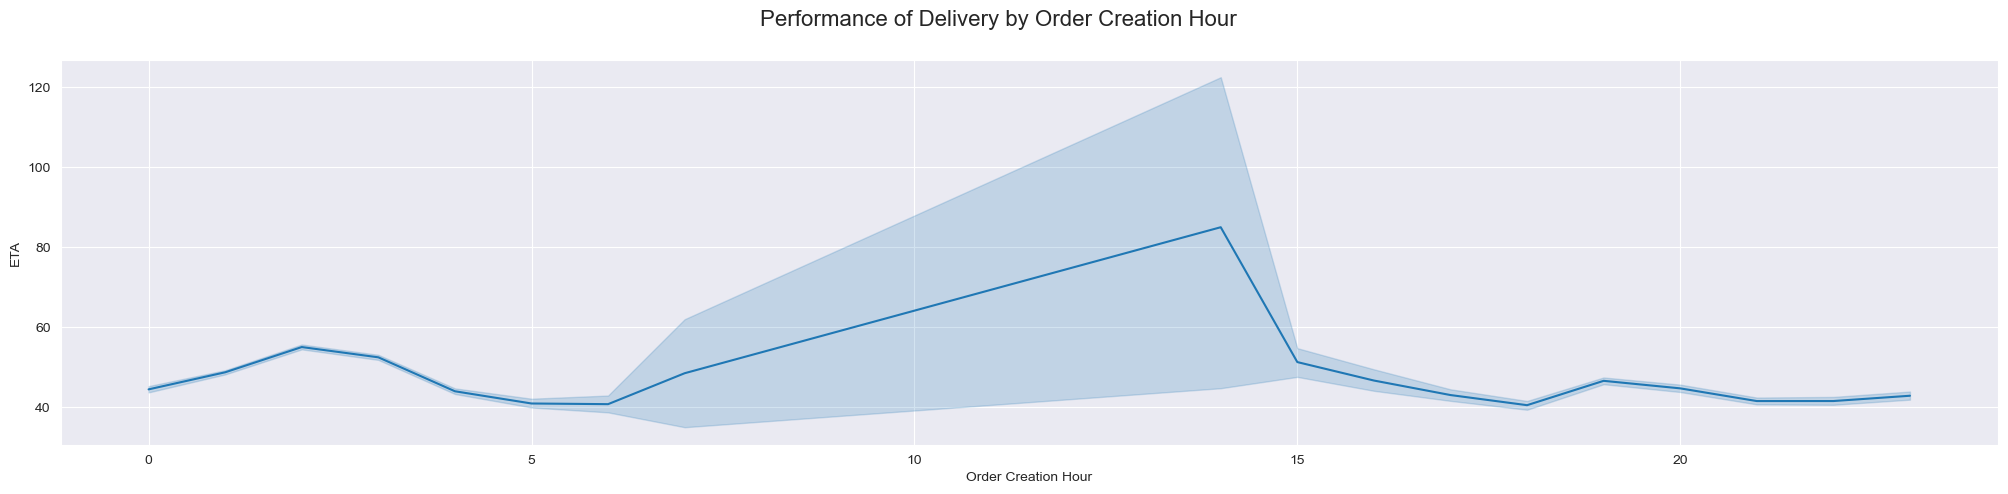

In [21]:
#----Effect of hour on ETA----
from pyspark.sql.functions import hour,col

df = df.withColumn("hour", hour(col('created_at')))
pandas_df = df.dropna().sample(False,0.15,seed=42).toPandas()

plt.figure(figsize=(25,5))
sns.lineplot(x=pandas_df["hour"],y=pandas_df["eta"])
plt.suptitle("Performance of Delivery by Order Creation Hour", fontsize=16)
plt.xlabel('Order Creation Hour')
plt.ylabel('ETA')
plt.show()   

**Observation**
- Order takes more eta to deliver when it is placed during afternoon.

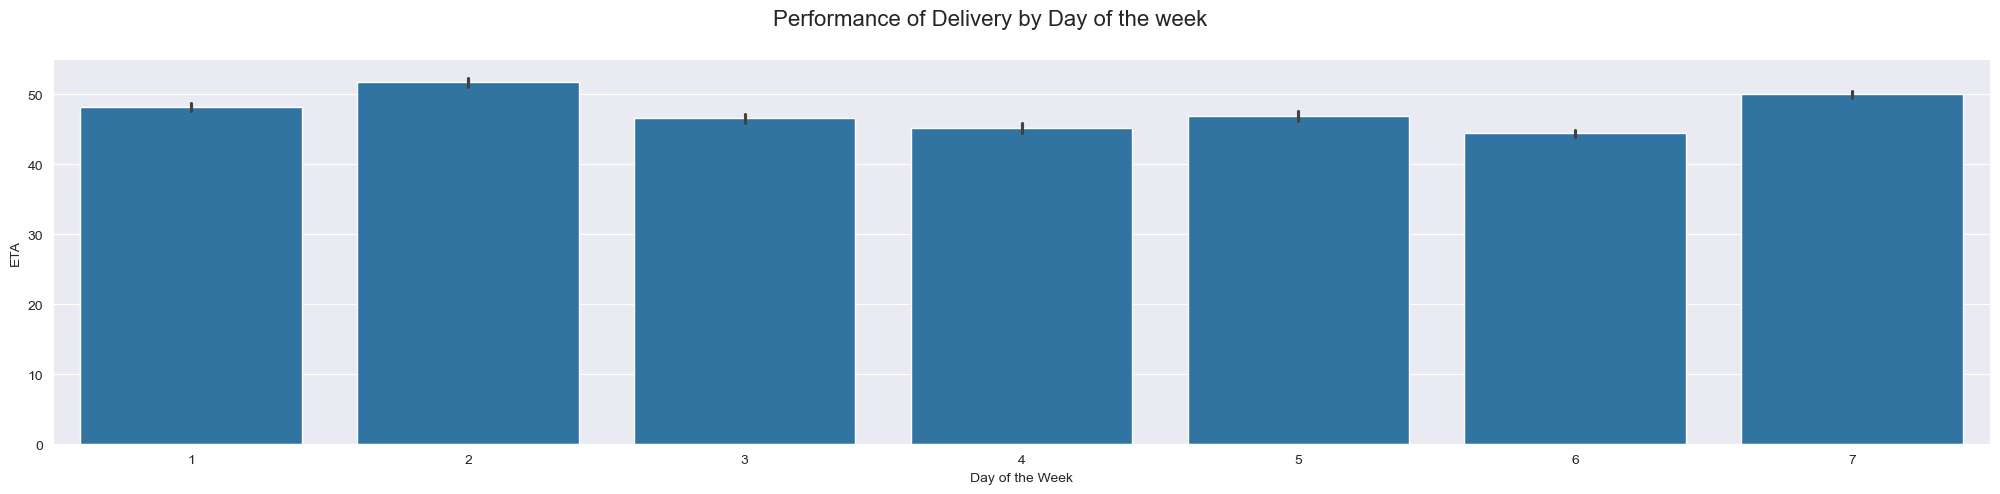

In [22]:
#----Effect of weekday on ETA----
from pyspark.sql.functions import dayofweek

df = df.withColumn("day_of_week", dayofweek(col('created_at')))
pandas_df = df.dropna().sample(False,0.15,seed=42).toPandas()

plt.figure(figsize=(25,5))
sns.barplot(x=pandas_df["day_of_week"],y=pandas_df["eta"])
plt.suptitle("Performance of Delivery by Day of the week", fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('ETA')
plt.show()   

In [23]:
# Appending New Feature to respective columns
categorical_cols.append('day_of_week')
categorical_cols.append('hour')
target_var = 'eta'

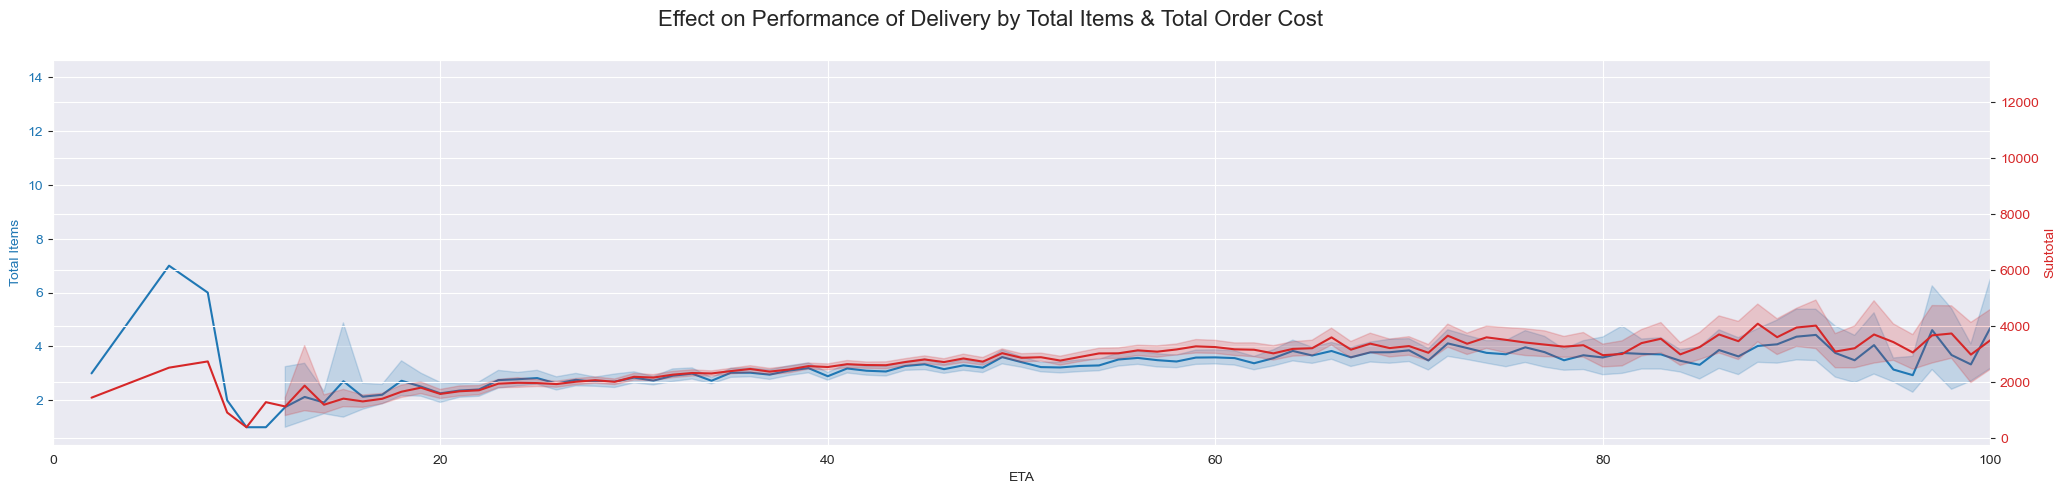

In [24]:
###----Effect on Performance of Delivery by Total Items & Total Order Cost---
fig, ax1 = plt.subplots(figsize=(25, 5))

color = 'tab:blue'
ax1.set_xlabel('ETA')
ax1.set_ylabel('Total Items', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_items"], ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Subtotal', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["subtotal"], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.suptitle("Effect on Performance of Delivery by Total Items & Total Order Cost", fontsize=16)
plt.xlim(0,100)
plt.show()

**Observation**
- No concrete visual pattern observed between Items Order Cost and eta.

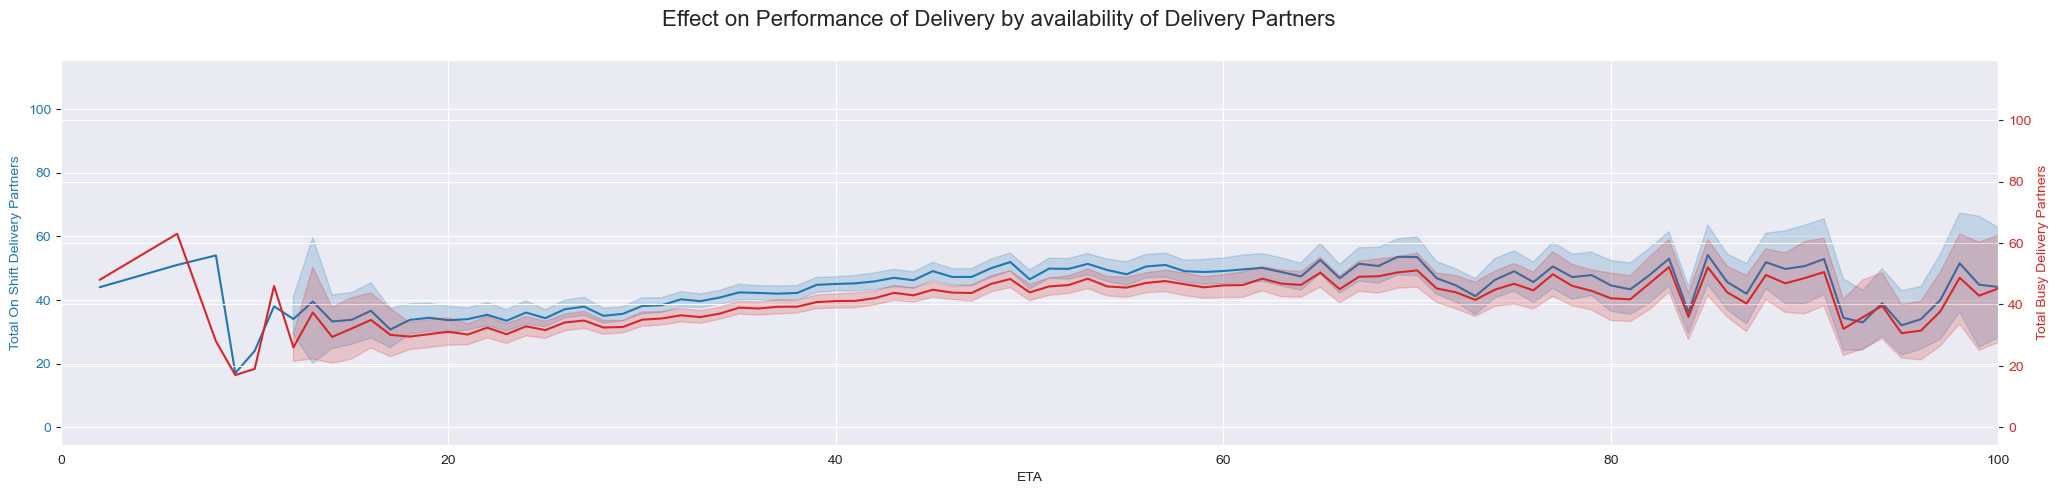

In [25]:
###----Analyze connection between total_onshift_partners 7 total_busy_partners w.r.t to eta---
fig, ax1 = plt.subplots(figsize=(25, 5))

color = 'tab:blue'
ax1.set_xlabel('ETA')
ax1.set_ylabel('Total On Shift Delivery Partners', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_onshift_partners"], ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Busy Delivery Partners', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_busy_partners"], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.suptitle("Effect on Performance of Delivery by availability of Delivery Partners", fontsize=16)
plt.xlim(0,100)
plt.show()

**Observation**
- No concrete information could be gathered from the visuals.

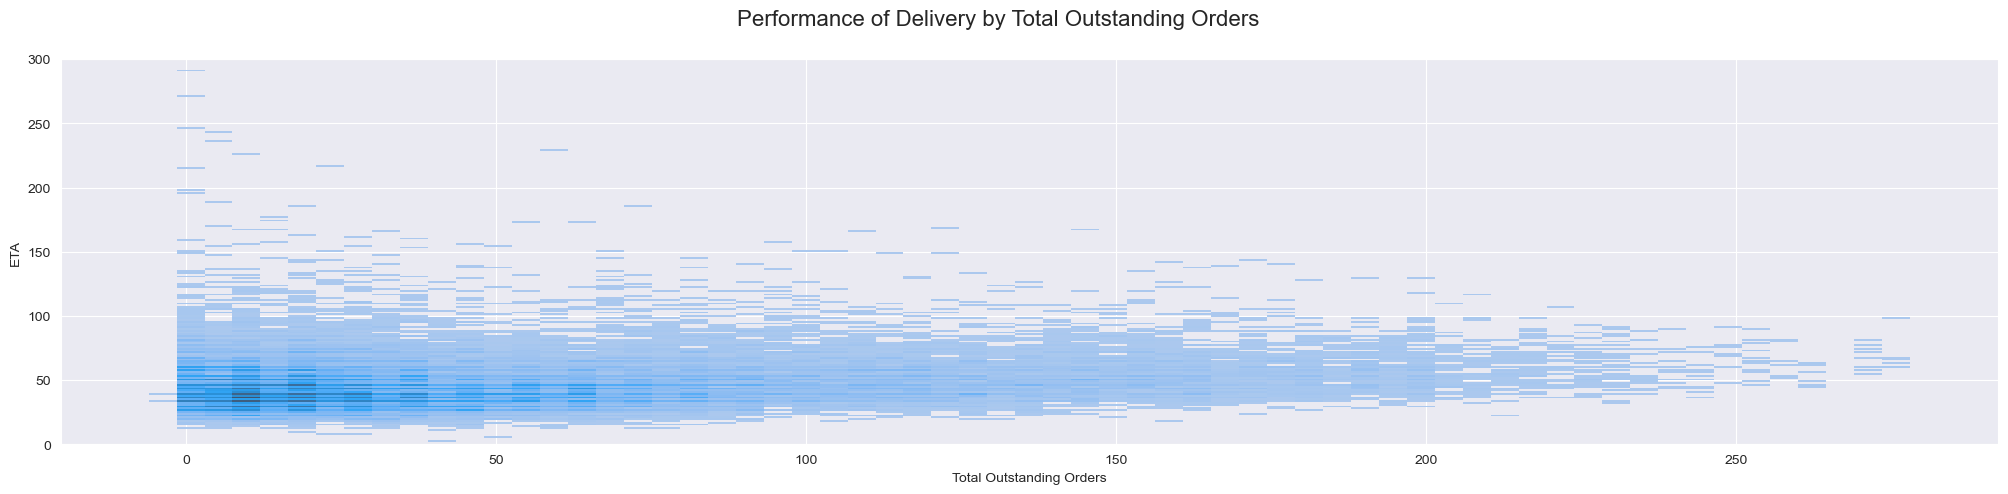

In [26]:
#---Total Outstanding Orders and Eta---
plt.figure(figsize=(25,5))
sns.histplot(data=pandas_df, x='total_outstanding_orders', y = 'eta')
plt.ylim(0,300)
plt.suptitle("Performance of Delivery by Total Outstanding Orders", fontsize=16)
plt.xlabel('Total Outstanding Orders')
plt.ylabel('ETA')
plt.show()  

**Observation**
- Slight pattern observed, whereas the pending orders increase the eta also increases.

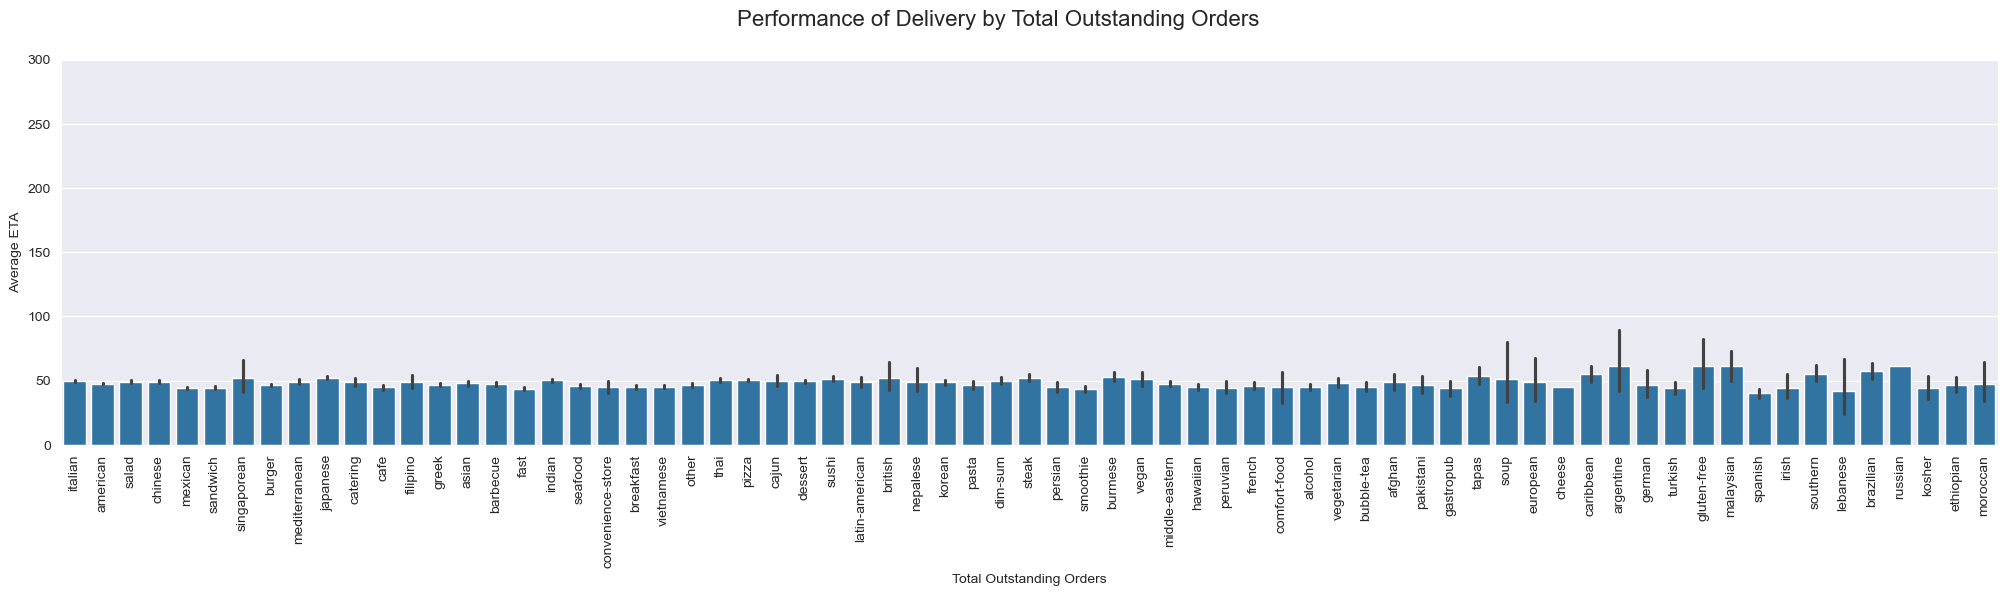

In [27]:
#---Analysis between ETA and Store Primary Category---
plt.figure(figsize=(25,5))
sns.barplot(data=pandas_df, x='store_primary_category', y = 'eta')
plt.ylim(0,300)
plt.suptitle("Performance of Delivery by Total Outstanding Orders", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Total Outstanding Orders')
plt.ylabel('Average ETA')
plt.show()  

**Observation**
- Comfort Food generally takes more time to deliver.

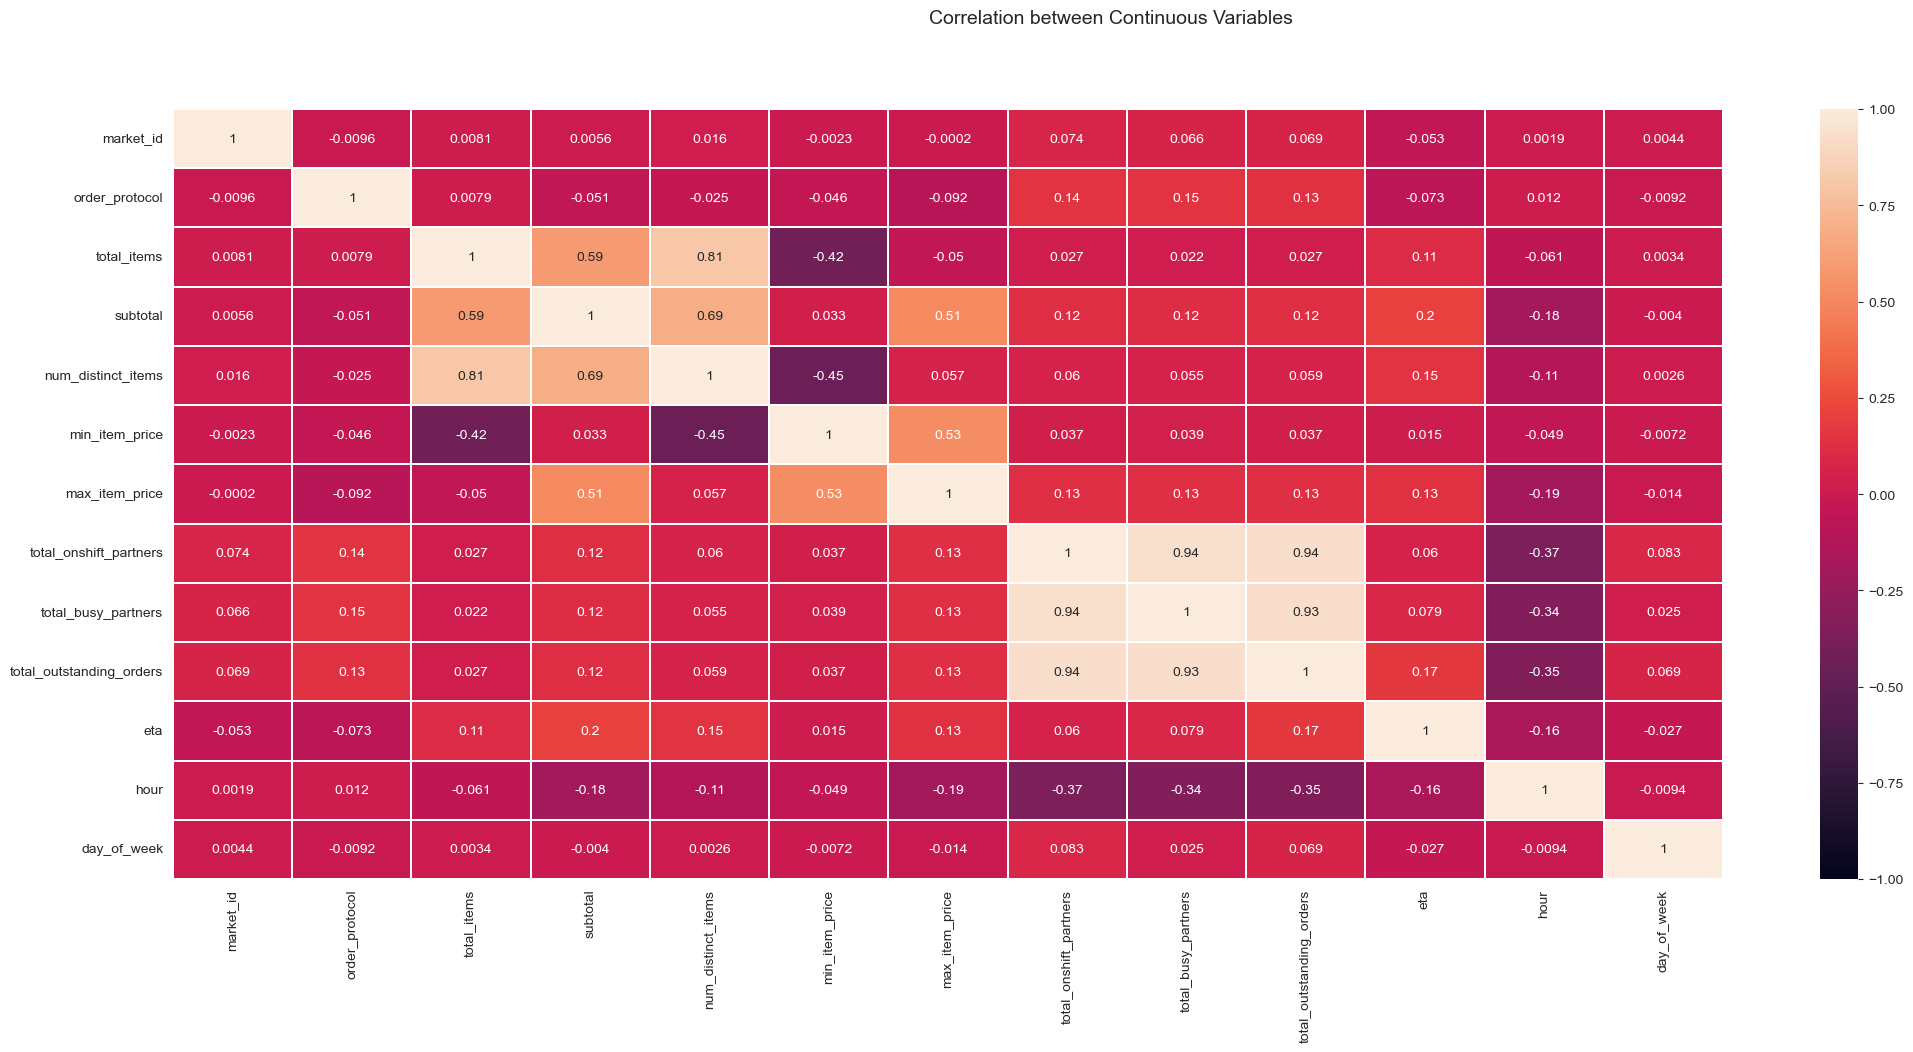

In [28]:
#---Verify Correlation Between Continuous Cols---
plt.figure(figsize=(25,10))
sns.heatmap(pandas_df.corr(numeric_only=True),annot=True,linewidths='0.01', vmin=-1,vmax=1)
plt.suptitle("Correlation between Continuous Variables", fontsize=14)
plt.show()  

**Observation**
- Total Items, Subtotal and Number of Distinct Items are Highly Correlated.
- Partners and Outstanding Orders also show Very High Correlation.
- Minimum Item Price shows negative Correlation with total_items and Num of Distinct Items.

In [29]:
#---Outlier Analysis---
def iqr_outlier_detection(data, columns):
    bounds = {}
    
    for col_name in columns:
        quantiles = data.approxQuantile(col_name, [0.25, 0.75], 0.05)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        bounds[col_name] = (lower_bound, upper_bound)
        
    outlier_counts = {}
    total_counts = data.count()
    
    for col_name in columns:
        lower_bound, upper_bound = bounds[col_name]
        outliers = data.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))
        outlier_count = outliers.count()
        outlier_percentage = np.round( (outlier_count / total_counts) * 100,2)
        outlier_counts[col_name] = outlier_percentage
        
    return outlier_counts

iqr_outlier_detection(df,continuous_cols)

{'total_items': 4.86,
 'subtotal': 5.84,
 'min_item_price': 3.25,
 'max_item_price': 4.77,
 'total_onshift_partners': 2.16,
 'total_busy_partners': 1.46,
 'total_outstanding_orders': 4.66}

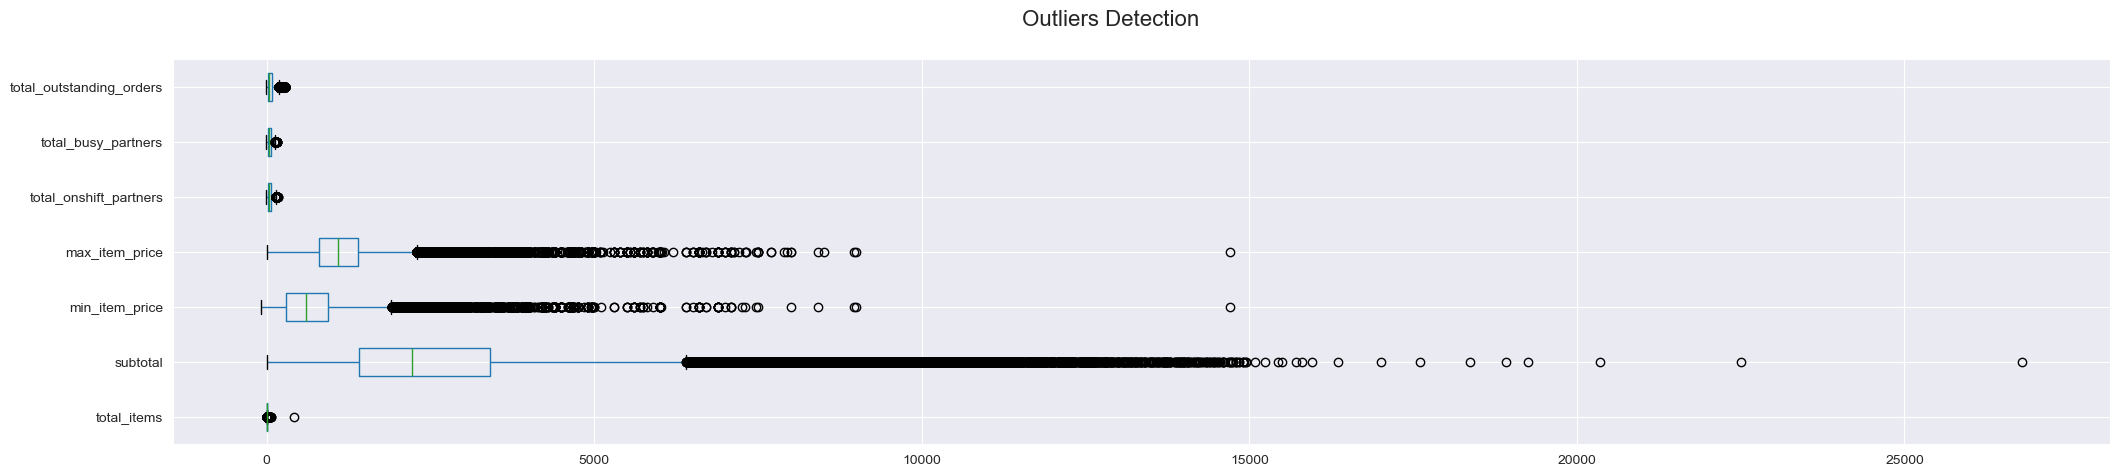

In [30]:
# Plotting Boxplot
df.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()

**Observation**
- Outliers observed in total_items, max_item_price and subtotal most.

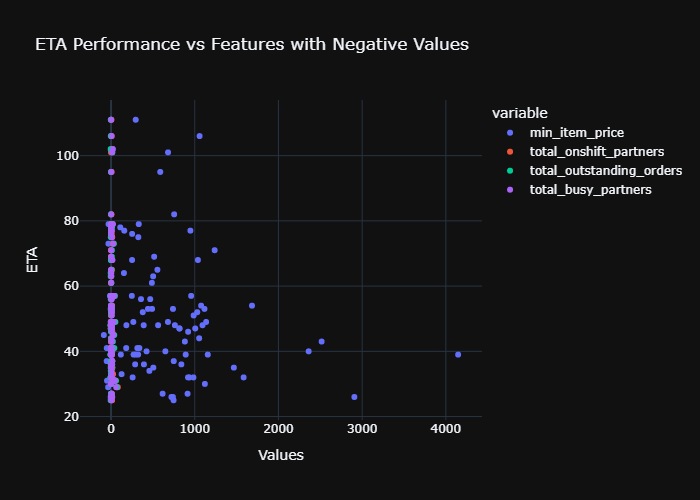

In [31]:
# Analyzing Negative Values in Features
from pyspark.sql.functions import col
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab+png"    # Setting Plotly renders for both Jupyter and PNG

negative_cols = ['min_item_price','total_onshift_partners','total_outstanding_orders','total_busy_partners']
negative_pd_df = df.filter( (col('min_item_price')<0) | (col('total_onshift_partners')<0)  | (col('total_outstanding_orders')<0) 
          | (col('total_busy_partners')<0)  ).select(*negative_cols+['eta']).dropna().toPandas()
melted_df = negative_pd_df.melt(id_vars=['eta'], value_vars=negative_cols, var_name='variable', value_name='value')

fig = px.scatter(melted_df, x='value', y='eta',color='variable',title='ETA Performance vs Features with Negative Values')
fig.update_layout(xaxis_title='Values', yaxis_title='ETA')
fig.show()

**Observation**
- Negative Values could indicate, refund ore free product in min item price.
- Negative values in other could denote a state where delivery personals are available in excess or less indicating either. 

# Data Preprocessing

#### Data Imputation

In [32]:
# Dropping all those rows where we don't know actual delivery time.
df_filtered = df.dropna(subset=['actual_delivery_time'])
df_filtered.limit(5)

# Dropping where both market_id and store_primary_category is null
df_filtered = df_filtered.filter(~(df.market_id.isNull() & df.store_primary_category.isNull()))

In [33]:
# Imputing Store Primary Category with Mode of Market ID
from pyspark.sql import functions as F
from pyspark.sql.window import Window

df_filtered = df_filtered.fillna({"market_id": -1})     # Marking -1 as NULL, for manual imputation

most_frequent_category = df_filtered.groupBy("market_id", "store_primary_category") \
    .count() \
    .withColumn("rank", F.row_number().over(Window.partitionBy("market_id").orderBy(F.desc("count")))) \
    .filter("rank = 1") \
    .select("market_id", "store_primary_category")

most_frequent_category = most_frequent_category.withColumnRenamed("store_primary_category", "most_frequent_category")
most_frequent_category.limit(5)

market_id,most_frequent_category
-1.0,american
1.0,american
2.0,mexican
3.0,american
4.0,pizza


In [34]:
# Imputing with selective Mode
df_filtered = df_filtered.join(most_frequent_category, on=["market_id"], how="left").withColumn(
    "store_primary_category",
    F.coalesce(df["store_primary_category"], most_frequent_category["most_frequent_category"])
).drop(most_frequent_category["most_frequent_category"])
df_filtered.limit(5)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta,hour,day_of_week
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0,22,6
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0,21,3
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,american,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0,20,5
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,american,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0,21,3
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,american,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0,2,1


In [35]:
# Rolling back NULL in market_id
df_filtered = df_filtered.withColumn("market_id", F.when(df_filtered["market_id"] == -1, None).otherwise(df_filtered["market_id"]))

In [36]:
# Imputing Continuous Columns
from sklearn.impute import KNNImputer
pandas_df = df_filtered.toPandas()
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(pandas_df[continuous_cols +["market_id","order_protocol"]])    
# >>> could have also used Dask KNNImputer, since it supports parallelization

In [37]:
# Joining Imputed DF with original
non_null_cat = [
    'store_id',
    'store_primary_category',
    'num_distinct_items',
    'day_of_week',
    'hour'
]
imputed_df = pd.DataFrame(imputed_array, columns=continuous_cols + ["market_id","order_protocol"])
concat_df = pd.concat([pandas_df[[target_var] + temporal_cols + non_null_cat], imputed_df], axis=1)
df_imputed = spark.createDataFrame(concat_df)
df.limit(5)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta,hour,day_of_week
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0,22,6
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0,21,3
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0,20,5
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NULL,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0,21,3
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NULL,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0,2,1


In [38]:
# Verifying Total NaN's
concat_df.isna().sum()

eta                         0
created_at                  0
actual_delivery_time        0
store_id                    0
store_primary_category      0
num_distinct_items          0
day_of_week                 0
hour                        0
total_items                 0
subtotal                    0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
market_id                   0
order_protocol              0
dtype: int64

In [39]:
# Saving File
concat_df.to_csv("../data/clean/imputed.csv", index=False)

#### Encoding Dataset

In [40]:
df_imputed = spark.read.csv("../data/clean/imputed.csv", header=True, inferSchema=True)

**Explanation**
- Only need to encode `store_id` and `store_primary_category`
- For both we are going to use target encoding

In [41]:
# Target Encoding
store_id_mean = df_imputed.groupBy('store_id').agg(F.mean(target_var).alias('store_id_mean_target'))
store_primary_category_mean = df_imputed.groupBy('store_primary_category').agg(F.mean(target_var).alias('store_primary_category_mean_target'))
df_imputed = df_imputed.join(store_id_mean, on='store_id', how='left')
df_imputed = df_imputed.join(store_primary_category_mean, on='store_primary_category', how='left')

# Replace original columns with the mean-encoded values
df_imputed = df_imputed.withColumnRenamed('store_id', 'original_store_id') \
                       .withColumnRenamed('store_primary_category', 'original_store_primary_category') \
                       .withColumnRenamed('store_id_mean_target', 'store_id') \
                       .withColumnRenamed('store_primary_category_mean_target', 'store_primary_category')

columns_to_drop = ['actual_delivery_time', 'created_at', 'original_store_id', 'original_store_primary_category']
df_imputed = df_imputed.drop(*columns_to_drop)

#### Handling Negative Values

In [42]:
from pyspark.sql.functions import col
neg_cols= ['min_item_price', 'total_onshift_partners', 'total_outstanding_orders', 'total_busy_partners']
for column in neg_cols:
    df_imputed = df_imputed.filter(col(column) >= 0)

**Explanation**
- These values can be a typo or might be a scenario where it makes sense in business context. 
- For now, I am treating this as an anomaly and dropping rows with negative columns in these groups, the reason for this behaviour is that destructive in case of Log Transformation and Scaling as well.
- Moreover, Log Norm distributions can't have 0 or negative values.


#### Handling Log Normal Distributions

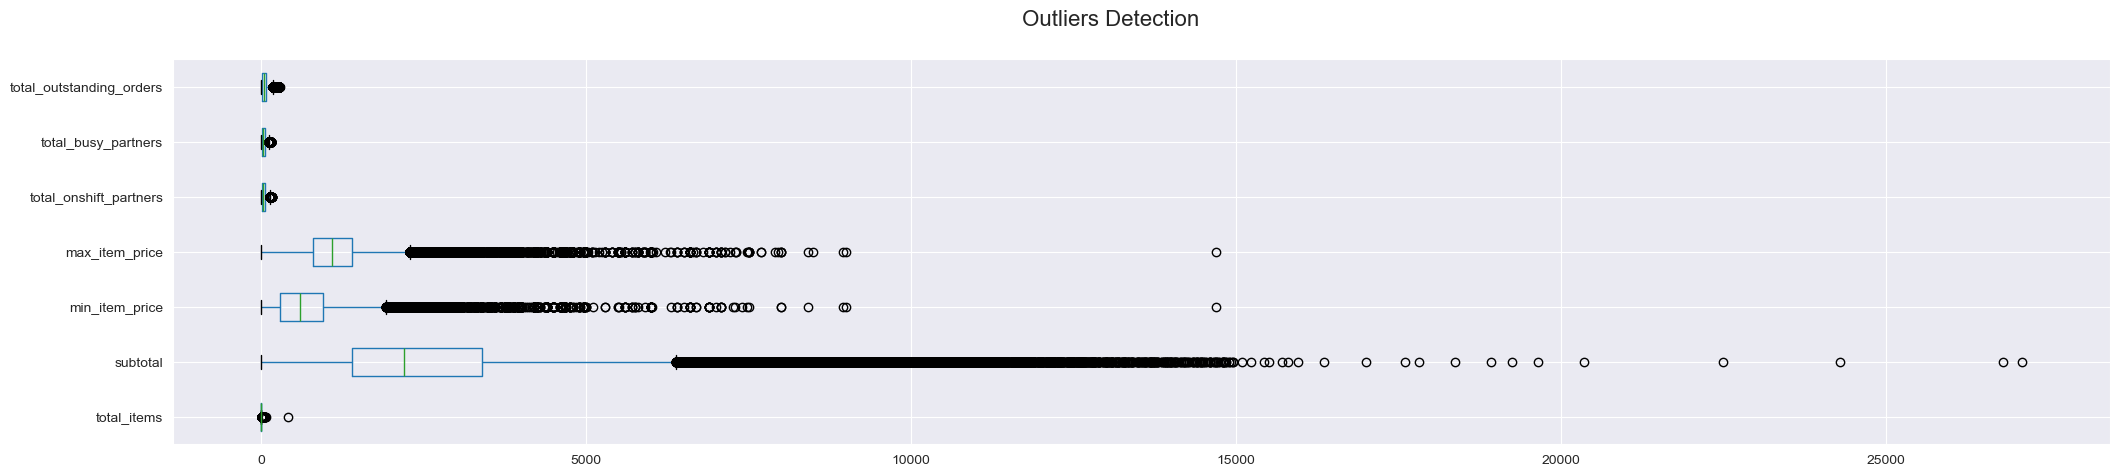

In [43]:
# Plotting Boxplot
df_imputed.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()

In [44]:
# Reducing the affect of Outliers on log normal distributions
for col in continuous_cols:
        df_imputed = df_imputed.withColumn(col, F.log(F.col(col) + 1e-15))

**Explanation**
- A log normal value can never have negative values, so we are handling it by skipping apply log normal here.

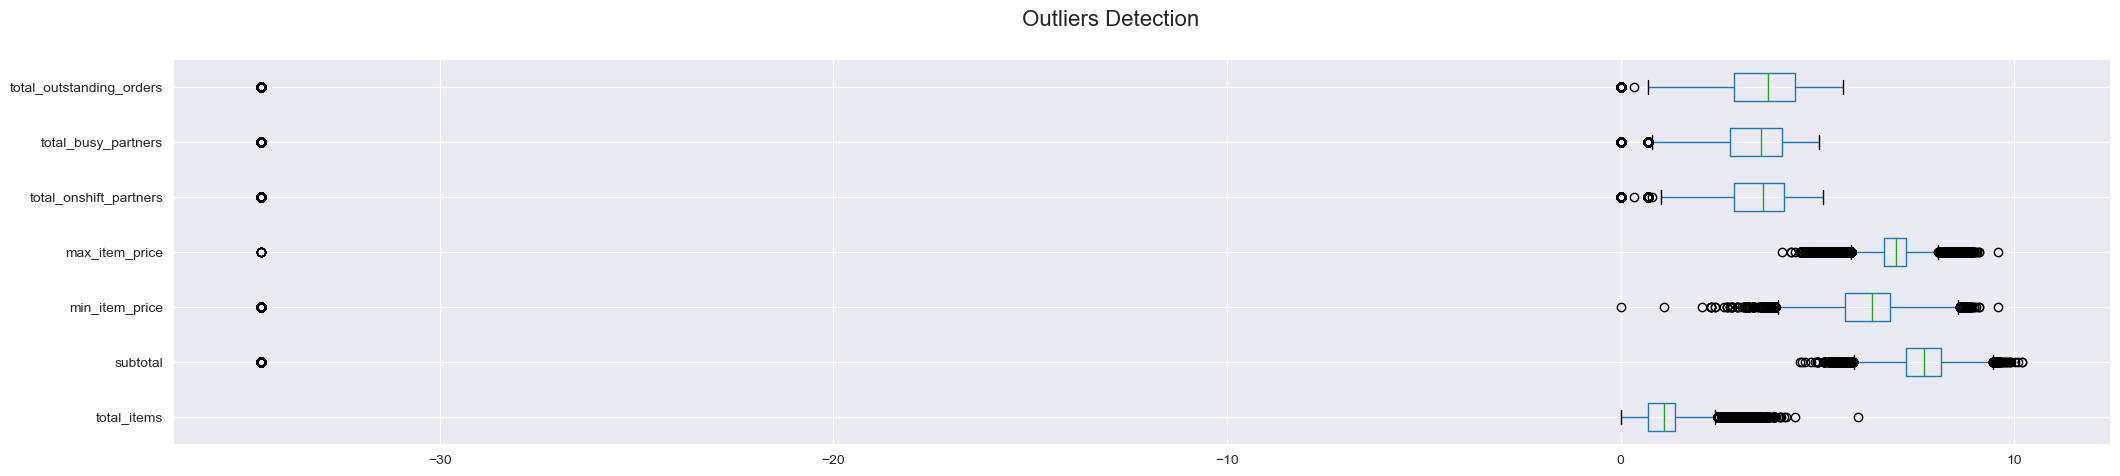

In [45]:
# Plotting Boxplot
df_imputed.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()

In [46]:
# Saving Data -> to avoid re-run of whole script
df_imputed.toPandas().to_csv("../data/clean/encoded.csv", index=False)

#### Outliers Detection using LOF

Outliers can skew the regressor, forcing network to learn noise and overfitting on the same. To avoid this behaviour we try to remove the outliers. Few methods through which we can remove outliers are
- Z Score: This approach removes outliers from certain standard deviation away from the mean.
- IQR: This approach uses Lower and Upper Bound for each variable on the basis of quantiles.
- Local Outlier Factors: Unlike above methods which are univariate in nature. This can analyze Outliers in higher dimension. It also manages to identify local outliers unlike others which are generally used to identify global.

Here we are going to implement LOF for outliers detection. 

In [47]:
df_encoded = pd.read_csv('../data/clean/encoded.csv')
df_encoded.head(5)

,eta,num_distinct_items,day_of_week,hour,total_items,subtotal,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,market_id,order_protocol,store_id,store_primary_category
0,63.0,4,6,22,1.386294e+00,8.143517,6.322565,7.122060,3.496508e+00,2.639057e+00,3.044522,1.0,1.0,63.000000,47.833310
1,67.0,1,3,21,1.110223e-15,7.549609,7.244228,7.244228,1.110223e-15,6.931472e-01,0.693147,2.0,2.0,48.076923,44.721816
2,30.0,1,5,20,1.110223e-15,7.549609,7.549609,7.549609,1.110223e-15,-3.453878e+01,-34.538776,3.0,1.0,48.076923,47.833310
3,51.0,5,3,21,1.791759e+00,8.839277,6.396930,7.495542,1.110223e-15,1.110223e-15,0.693147,3.0,1.0,48.076923,47.833310
4,40.0,3,1,2,1.098612e+00,8.268732,7.003065,7.377759,1.791759e+00,1.791759e+00,2.197225,3.0,1.0,48.076923,47.833310


In [48]:
# Splitting dataset
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42) # train/test
train_df, val_df = train_test_split(train_df, test_size=0.35, random_state=42) # train/val

**Scaling the Dataset**

Scaling ensures that all features contribute equally to the training process. Eventually helping in faster convergence of the network/model.

I am scaling using Standard Scaler, since some distribution in my dataset were following log normal nature.

In [49]:
# Standardizing Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_df[continuous_cols+categorical_cols] = scaler.fit_transform(train_df[continuous_cols+categorical_cols])
val_df[continuous_cols+categorical_cols] = scaler.transform(val_df[continuous_cols+categorical_cols])
test_df[continuous_cols+categorical_cols]  =scaler.transform(test_df[continuous_cols+categorical_cols])

In [50]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)  # Novelty for ability to detect anomalies in Test Data
lof_model = lof.fit(train_df.loc[:,train_df.columns != target_var].values)

**Explanation**
- We'll fit our lof model only on training set, so that our model generalizes instead of trying to learn noise. 

In [51]:
# Predicting outliers using LOF fitted model
train_outliers = lof.predict(train_df.loc[:,train_df.columns != target_var].values)
val_outliers = lof.predict(val_df.loc[:,val_df.columns != target_var].values)
test_outliers = lof.predict(test_df.loc[:,test_df.columns != target_var].values)

In [52]:
total_outliers_train = sum(train_outliers == -1)
total_outliers_val = sum(val_outliers == -1)
total_outliers_test= sum(test_outliers == -1)

print(f"Train outliers detected: {total_outliers_train}")
print(f"Validation outliers detected: {total_outliers_val}")
print(f"Test outliers detected: {total_outliers_test}")

val_df = val_df[val_outliers == 1]
test_df = test_df[test_outliers == 1]
train_df = train_df[train_outliers == 1]

Train outliers detected: 4314
Validation outliers detected: 2810
Test outliers detected: 2026


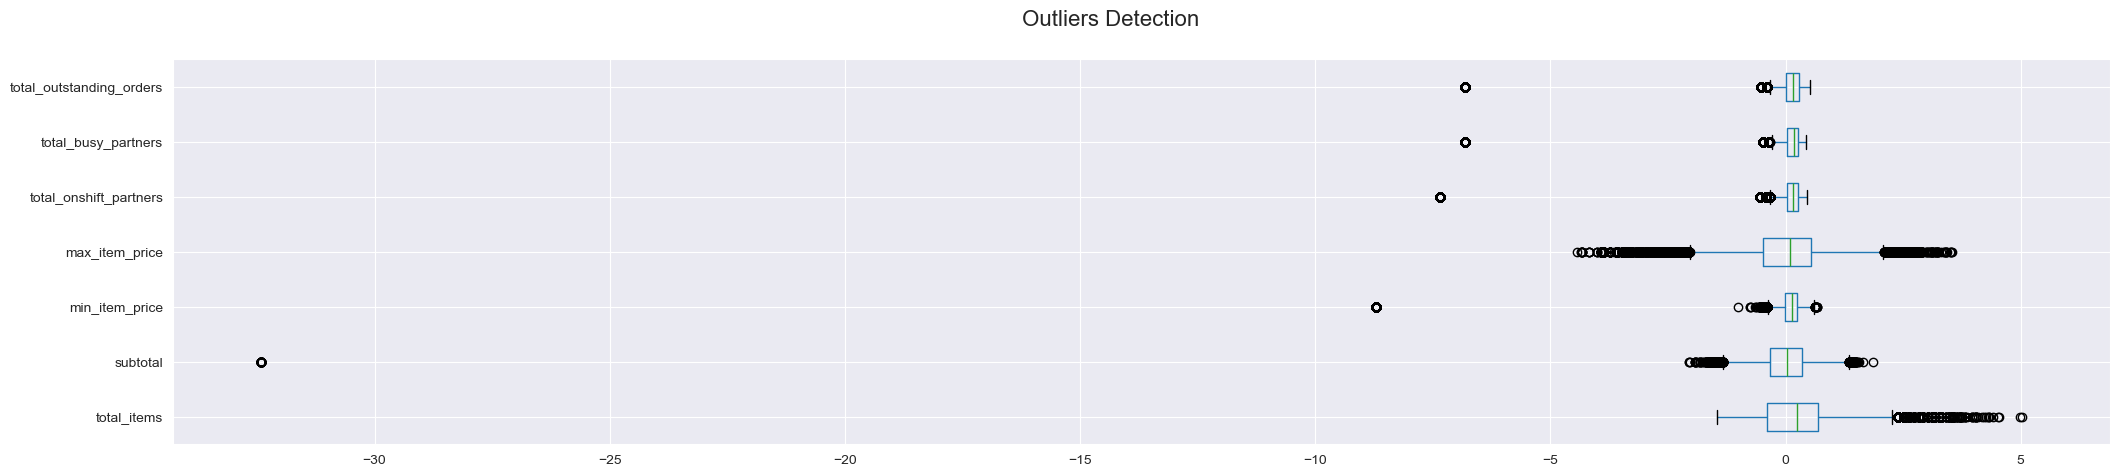

In [53]:
# Plotting Boxplot
train_df[continuous_cols].boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()

**Observation**
- LOF works on High Dimensional, we cannot observe its effect properly here.

In [54]:
# Saving data
train_df.to_csv("../data/train/train.csv")
val_df.to_csv("../data/validation/val.csv")
test_df.to_csv("../data/test/test.csv")

# Data Modelling

### Simple Model

In [55]:
# Setting Seed for Torch
import torch
import random

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [56]:
# Splitting Train/Test/Validation into X & y
train_df = pd.read_csv('../data/train/train.csv').drop(columns='Unnamed: 0')
val_df = pd.read_csv('../data/validation/val.csv').drop(columns='Unnamed: 0')
test_df = pd.read_csv('../data/test/test.csv').drop(columns='Unnamed: 0')

target_var = 'eta'

X_train = train_df.drop(target_var, axis=1)
y_train = train_df[target_var]
X_val = val_df.drop(target_var, axis=1)
y_val = val_df[target_var]
X_test = test_df.drop(target_var, axis=1)
y_test = test_df[target_var]

In [57]:
# Validating CUDA functioning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Computation:",device)

Available Computation: cuda


In [58]:
# Convert dataset for torch tensors since it support parallelization and much more
from torch.utils.data import DataLoader, TensorDataset

batch_size=512
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [59]:
# Creating Simple Network of Neurons 
import torch.nn as nn

class SimpleNNModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        return self.model(x)
    
    # Kernel Initializer 
    def initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.constant_(layer.weight, 0)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

input_dim = X_train.shape[1]
model = SimpleNNModel(input_dim)

print(model)

SimpleNNModel(
  (model): Sequential(
    (0): Linear(in_features=14, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [60]:
# Training the model
from torch.optim import Adam
from sklearn.metrics import mean_squared_error

def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_loss = 0.0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()   # Resets Gradient values to 0
            predictions = model(X_batch).squeeze() # Predict and matches output dimensions
            loss = criterion(predictions, y_batch) 
            loss.backward()
            optimizer.step()  # Update Weights
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch+1)%1 ==0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
        
    plt.figure(figsize=(25,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Training and Validation Loss')
    plt.show()
        
    return model

In [61]:
# Warnings Filter
import mlflow
import mlflow.pytorch
import logging
import warnings

mlflow.autolog(disable=True)
logging.getLogger("mlflow").setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=UserWarning, module='mlflow')
logging.getLogger("py3j").setLevel(logging.ERROR)
logging.getLogger("mlflow.utils").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message="Distutils was imported before Setuptools")
warnings.filterwarnings("ignore", message="Setuptools is replacing distutils")

mlflow.set_tracking_uri("../mlruns/")

Epoch 1/10, Training Loss: 2033.8210481007893, Validation Loss: 1373.545053426502
Epoch 2/10, Training Loss: 461.5242195294963, Validation Loss: 1106.3254147131465
Epoch 3/10, Training Loss: 366.42814956117354, Validation Loss: 1072.7493228356816
Epoch 4/10, Training Loss: 343.10420030034703, Validation Loss: 1055.4366077311988
Epoch 5/10, Training Loss: 330.6316145158516, Validation Loss: 1046.883110713033
Epoch 6/10, Training Loss: 320.7226981710522, Validation Loss: 1036.8504425345116
Epoch 7/10, Training Loss: 314.83102136829206, Validation Loss: 1030.976599091465
Epoch 8/10, Training Loss: 310.58054811290043, Validation Loss: 1027.3052902962397
Epoch 9/10, Training Loss: 307.9979967118205, Validation Loss: 1025.4867408530226
Epoch 10/10, Training Loss: 306.2934708366796, Validation Loss: 1023.8237091360741


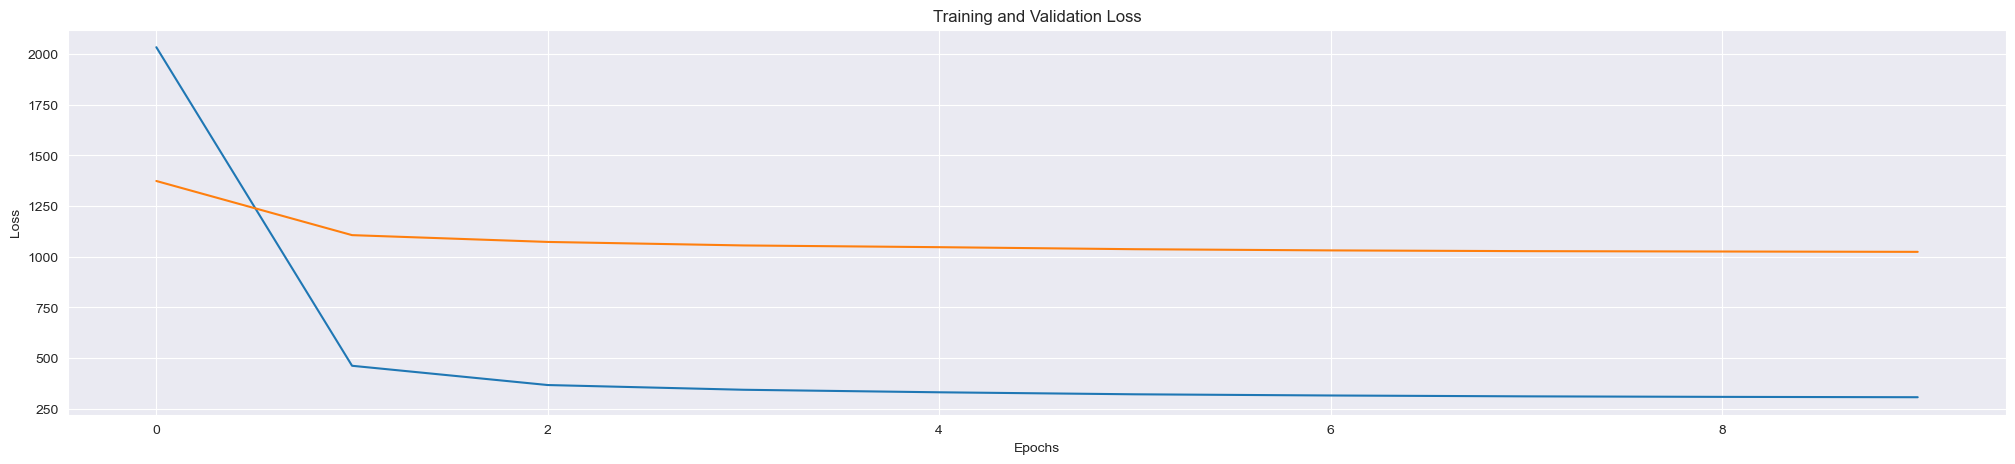

Mean Squared Error on Validation Set: 1030.2059326171875


In [62]:
# Logging Simple Model
mlflow.set_experiment("Simple NN")

with mlflow.start_run():
    model = train_model(model, train_loader, val_loader)
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("learning_rate", 0.001),
    mlflow.log_param("batch_size", 512)
    
    model.eval()
    with torch.no_grad():
        predictions = model(val_dataset[:][0]).squeeze()
        mse = mean_squared_error(val_dataset[:][1], predictions.numpy())
    
    mlflow.log_metric("test_loss", mse)
    print(f'Mean Squared Error on Validation Set: {mse}')

**Observation**
- Model has already converged, We'll try to improve this by creating complex model.
- Overfitting observed, We can try Regularization methods to solve Overfitting problems.  

### Complex Model

In [63]:
import torch.nn as nn

class EnhancedNNModel(nn.Module):
    def __init__(self, input_dim, bn_momentum=0.1, bn_eps=1e-5):
        super(EnhancedNNModel, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),
        )
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, momentum=bn_momentum, eps=bn_eps),
        )
        self.hidden_layer2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, momentum=bn_momentum, eps=bn_eps),
        )
        self.hidden_layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),
        )
        self.hidden_layer4 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),
        )
        self.output_layer = nn.Linear(32, 1)

        self.initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Sequential):
                for sublayer in layer:
                    if isinstance(sublayer, nn.Linear):
                        nn.init.kaiming_uniform_(sublayer.weight, nonlinearity='relu')
                        if sublayer.bias is not None:
                            nn.init.constant_(sublayer.bias, 0)
                    elif isinstance(sublayer, nn.BatchNorm1d):
                        nn.init.constant_(sublayer.weight, 1)
                        nn.init.constant_(sublayer.bias, 0)

input_dim = X_train.shape[1]
model = EnhancedNNModel(input_dim)

print(model)

EnhancedNNModel(
  (input_layer): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden_layer1): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [64]:
def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
                    
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch+1) % 10 == 0: 
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    plt.figure(figsize=(25,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Training and Validation Loss')
    plt.show()

    return model

Epoch 10/50, Training Loss: 266.5779603322347, Validation Loss: 986.2305469698119
Epoch 20/50, Training Loss: 262.2123585542043, Validation Loss: 982.4394384587853
Epoch 30/50, Training Loss: 258.3968322277069, Validation Loss: 982.5154589310433
Epoch 40/50, Training Loss: 254.8101112047831, Validation Loss: 984.3758410111215
Epoch 50/50, Training Loss: 252.3979472319285, Validation Loss: 982.3087374492757


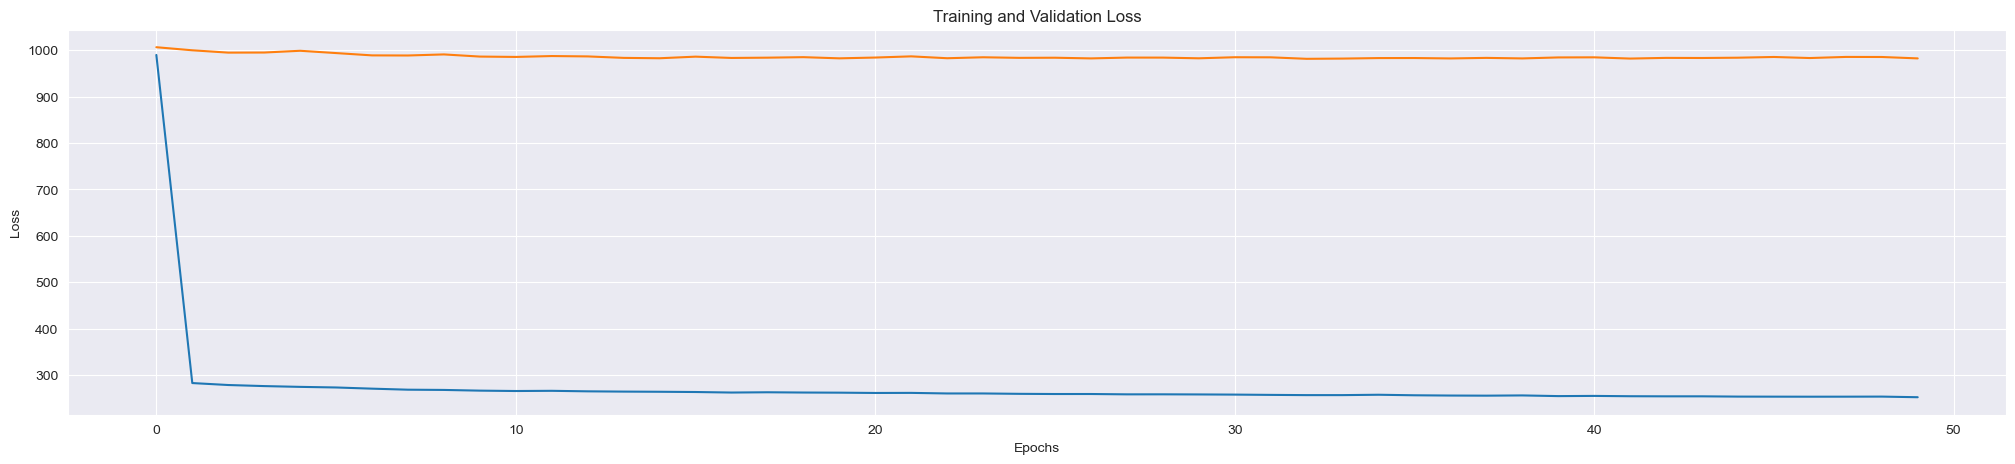

Mean Squared Error on Validation Set: 988.6914672851562


In [65]:
# Log experiment with MlFlow
mlflow.set_experiment("Enhanced NN")

with mlflow.start_run():
    mlflow.log_param("epochs", 50)
    mlflow.log_param("learning_rate", 0.01)
    mlflow.log_param("batch_size", 512)
    model = train_model(model, train_loader, val_loader, epochs = 50)
    mlflow.pytorch.log_model(model, "model")
    
    model.eval()
    with torch.no_grad():
        predictions = model(val_dataset[:][0]).squeeze()
        mse = mean_squared_error(val_dataset[:][1], predictions.numpy())
    
    mlflow.log_metric("test_loss", mse)
    print(f'Mean Squared Error on Validation Set: {mse}')

**Observation**
- No major difference observed between Simple and Complex model.
- Adding layers was not significantly effective, indicating model might not have very complex non linear relationships.
- We'll try to optimize this using HyperOpt.

### Hyper Optimization using Hyperopt

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining Tensors for optimizing on Batch Size and moving to GPU
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [67]:
import torch.nn as nn

class OptimizedNNModel(nn.Module):
    def __init__(self, input_dim, bn_momentum=0.1, bn_eps=1e-5):
        super(OptimizedNNModel, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),
        )
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, momentum=bn_momentum, eps=bn_eps),
        )
        self.hidden_layer2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, momentum=bn_momentum, eps=bn_eps),
        )
        self.hidden_layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),
        )
        self.hidden_layer4 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),
        )
        self.output_layer = nn.Linear(32, 1)

        self.initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Sequential):
                for sublayer in layer:
                    if isinstance(sublayer, nn.Linear):
                        nn.init.kaiming_uniform_(sublayer.weight, nonlinearity='relu')
                        if sublayer.bias is not None:
                            nn.init.constant_(sublayer.bias, 0)
                    elif isinstance(sublayer, nn.BatchNorm1d):
                        nn.init.constant_(sublayer.weight, 1)
                        nn.init.constant_(sublayer.bias, 0)

In [68]:
# Callback implementation for Early Stopping training, if no improvement in performance is observed
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

In [69]:
from hyperopt import STATUS_OK

def train_model(params):
    # Unpack parameters
    batch_size = int(params['batch_size'])
    learning_rate = params['learning_rate']
    epochs = int(params['epochs'])
    bn_momentum = params['bn_momentum']
    bn_eps = params['bn_eps']
    beta = params['beta1'],params['beta2']
    weight_decay = params['weight_decay']
    
    # Prepare data loaders with the given batch size
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
    
    input_dim = X_train.shape[1]
    model = OptimizedNNModel(input_dim, bn_momentum=bn_momentum, bn_eps=bn_eps).to(device)

    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, betas =beta, weight_decay=weight_decay)
    
    # Initializing Callback EarlyStop
    early_stopping = EarlyStopping(patience=3, min_delta=0.01)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            model.eval()
            with torch.no_grad():
                predictions = model(X_val_tensor).squeeze()
                val_loss = mean_squared_error(y_val_tensor.cpu().numpy(), predictions.cpu().numpy())
            
            return {'loss': val_loss, 'status': STATUS_OK, 'model': model}
        
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_tensor).squeeze()
        val_loss = mean_squared_error(y_val_tensor.cpu().numpy(), predictions.cpu().numpy())
    
    return {'loss': val_loss, 'status': STATUS_OK, 'model': model}

In [70]:
from hyperopt import fmin, tpe, hp, Trials

mlflow.set_experiment("Model HyperParam Optimization")

# Hyperparameter optimization space
space = {
    'epochs': 25,
    'batch_size': hp.quniform('batch_size', 32, 2048, 32),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),
    'bn_momentum': hp.uniform('bn_momentum', 0.01, 0.99),
    'bn_eps': hp.loguniform('bn_eps', -8, -1),
    'weight_decay': hp.loguniform('weight_decay', -8, -1),
    'beta1': hp.uniform('beta1', 0.6, 0.9),
    'beta2': hp.uniform('beta2', 0.9, 0.999),    
}

# Objective function for Hyperopt
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        result = train_model(params)
        mlflow.log_metric('val_loss', result['loss'])
        mlflow.pytorch.log_model(result['model'], 'model')
        return result

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=75, trials=trials)

print("Best parameters found: ", best)

100%|██████████| 75/75 [29:02<00:00, 23.23s/trial, best loss: 991.6577758789062] 
Best parameters found:  {'batch_size': 1248.0, 'beta1': 0.8698588701865128, 'beta2': 0.9201733653990161, 'bn_eps': 0.0011291228965207751, 'bn_momentum': 0.2459638907347962, 'learning_rate': 0.011684191827633432, 'weight_decay': 0.00038722934588798503}


**Observation**

- No major benefit observed by using Parameter Optimization
- Probably because no of trials were too less
- Since I ran this multiple times, Parameters I found to be optimal are:
    - `batch_size`: 32768, balance between epoch speed and good constant decrease in loss, I can increase this parameter high up, since I have enough GPU power to scale.
    - `learning_rate`: 0.005, good balance between faster learning and not overshooting optimal point.
    - `beta1` & `beta2` : 0.9 & 0.986. , chosen because upon various Hyperopt experiments, these were in general best beta values.
    - `weight_decay`: regularization parameter of 0.00005 was found to be most reasonable in my experiments. This is considerably low because Overfitting was not observed when compared with MAPE

### Fine-Tuned Model

#### Model Structure

Few observations I made from my experiments is that adding more hidden layers, often does not correlate with scale in performance. I also tried denoising strategy similar to Auto Regressor approach. Unfortunately the strategy was a complete disaster. Hence I settled for stacking more neurons in hidden layers so that it can formulate more complex features.

#### Activation Function

Activation functions can help to identify Non Linearity in our datasets. This non-linearity helps us to capture complex patterns in our dataset. It acts as a switch that determines whether to fire the 
neuron or not, essentially acting as ON/OFF switch. 

In this Project I'll be using SELU, a self normalizing function, Unlike ReLU it can provide negative values, resulting zero based average activation function. It can also handle Vanishing and Exploding Gradients, hence leads to faster convergence.

$$
f(x) = 
\begin{cases} 
\lambda x \ & \ x > 0 \\
\lambda \alpha (e^x - 1) \ & \  x \leq 0
\end{cases}
$$

where $\lambda$ and $\alpha$ are constants.

> NOTE: Need to adjust Kernel Initializer He Normal non linearity to linear, for optimal initialization for SELU

In [71]:
class DeepEnhancedNNModel(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.025):
        super(DeepEnhancedNNModel, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.SELU(),
            nn.Dropout(dropout_prob)
        )

        self.hidden_layers = nn.ModuleList()

        self.hidden_layers.append(nn.Sequential(
                nn.Linear(32, 128),
                nn.SELU(),
                nn.Dropout(dropout_prob)
            ))

        self.hidden_layers.append(nn.Sequential(
            nn.Linear(128, 256),
            nn.SELU(),
            nn.Dropout(dropout_prob)
        ))
            
        self.hidden_layers.append(nn.Sequential(
            nn.Linear(256, 512),
            nn.SELU(),
            nn.Dropout(dropout_prob)
        ))

        self.hidden_layers.append(nn.Sequential(
            nn.Linear(512, 1024),
            nn.SELU(),
            nn.Dropout(dropout_prob)
        ))
        
        self.output_layer = nn.Linear(1024, 1)
        
        self.initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Sequential) or isinstance(layer, nn.ModuleList):
                for sublayer in layer:
                    if isinstance(sublayer, nn.Linear):
                        nn.init.kaiming_normal_(sublayer.weight, nonlinearity='linear')
                        if sublayer.bias is not None:
                            nn.init.constant_(sublayer.bias, 0)

#### Loss Function

Loss function becomes the backbone of the networks on which back propagation happens, this acts as optimizing equation for our gradients which eventually leads to optimal weights.

In my experiments I observed, MSE was only penalizing larger errors, which was causing low penalty for small errors. To have the benefit of penalization on both larger and smaller values. I decided to use SmoothL1Loss as known as Hubber Loss:

$$
L_{\delta}(a) = 
\begin{cases} 
\frac{1}{2} (y - \hat{y})^2 & \text{for } |y - \hat{y}| \le \delta \\
\delta |y - \hat{y}| - \frac{1}{2} \delta^2  \ & \text{ otherwise} \\
\end{cases}
$$

Here, $\delta$ is a threshold parameter.

#### Optimizer

Optimizers are the method using which we update our weights. Using optimizers our gradients are able to calculate the route to optimal path. Although some optimizers could add variance in weight update step over preference to speed. Choosing optimizer correctly becomes crucial to optimize our weights as  quick as possible with low noise in weight update steps.

Here we are going to implement Adam since it combines the advantages of both SGD with Momentum and RMSProp. It provides faster convergence and lower variability when reaching optimal weights.

\begin{align*}
g_t &= \nabla_{\theta} f(\theta_{t-1}) \\
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align*}

In [72]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from builtins import round              # Reimporting because round was overridden by pyspark round

def train_model(params):
    learning_rate = params["learning_rate"]
    epochs = params["epochs"]
    beta1 = params["beta"][0]
    beta2 = params["beta"][1]
    weight_decay = params["weight_decay"]
    dropout_prob = params.get("dropout_prob")
    batch_size = params['batch_size']

    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = X_train.shape[1]
    model = DeepEnhancedNNModel(input_dim, dropout_prob=dropout_prob).to(device)
    criterion = nn.SmoothL1Loss(beta=3)
    optimizer = Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5)

    early_stopping = EarlyStopping(patience=10, min_delta=0.01)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        train_mape = 0.0
        train_mse = 0.0
        train_r2 = 0.0

        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()
            train_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
            train_mse += mean_squared_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
            train_r2 += r2_score(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())

        epoch_train_loss /= len(train_loader)
        train_mape = round(train_mape / len(train_loader), 6) * 100
        train_mse = round(train_mse / len(train_loader), 3)
        train_r2 = round(train_r2 / len(train_loader), 3)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        val_mape = 0.0
        val_mse = 0.0
        val_r2 = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).squeeze()
                val_loss = criterion(predictions, y_batch).item()
                epoch_val_loss += val_loss
                val_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
                val_mse += mean_squared_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
                val_r2 += r2_score(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())

        epoch_val_loss /= len(val_loader)
        val_mape = round(val_mape / len(val_loader), 6) * 100
        val_mse = round(val_mse / len(val_loader), 3) 
        val_r2 = round(val_r2 / len(val_loader), 3)
        val_losses.append(epoch_val_loss)

        scheduler.step(epoch_val_loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.3f}, Training MAPE: {train_mape:.3f}, Training MSE: {train_mse:.3f}, Validation Loss: {epoch_val_loss:.3f}, Validation MAPE: {val_mape:.3f}, Validation MSE: {val_mse:.3f}')

        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.3f}, Training MAPE: {train_mape:.3f}, Training MSE: {train_mse:.3f}, Validation Loss: {epoch_val_loss:.3f}, Validation MAPE: {val_mape:.3f}, Validation MSE: {val_mse:.3f}')

            model.eval()
            with torch.no_grad():
                test_loss = 0.0
                test_mape = 0.0
                test_mse = 0.0
                test_r2 = 0.0
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    predictions = model(X_batch).squeeze()
                    test_loss += criterion(predictions, y_batch).item()
                    test_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
                    test_mse += mean_squared_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
                    test_r2 += r2_score(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())

                test_loss /= len(test_loader)
                test_mape = round(test_mape / len(test_loader), 6) * 100
                test_mse = round(test_mse / len(test_loader), 3)
                test_r2 = round(test_r2 / len(test_loader), 3)

            return {
                'train_loss': round(epoch_train_loss, 3),
                'train_mape': train_mape,
                'train_mse': train_mse,
                'train_r2': train_r2,
                'val_loss': round(epoch_val_loss, 3),
                'val_mape': val_mape,
                'val_mse': val_mse,
                'val_r2': val_r2,
                'test_loss': round(test_loss, 3),
                'test_mape': test_mape,
                'test_mse': test_mse,
                'test_r2': test_r2,
                'model': model,
                'history_train': train_losses,
                'history_val': val_losses
            }

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_mape = 0.0
        test_mse = 0.0
        test_r2 = 0.0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch).squeeze()
            test_loss += criterion(predictions, y_batch).item()
            test_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
            test_mse += mean_squared_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
            test_r2 += r2_score(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())

        test_loss /= len(test_loader)
        test_mape = round(test_mape / len(test_loader), 3)
        test_mse = round(test_mse / len(test_loader), 3)
        test_r2 = round(test_r2 / len(test_loader), 3)

    return {
        'train_loss': round(epoch_train_loss, 3),
        'train_mape': train_mape,
        'train_mse': train_mse,
        'train_r2': train_r2,
        'val_loss': round(epoch_val_loss, 3),
        'val_mape': val_mape,
        'val_mse': val_mse,
        'val_r2': val_r2,
        'test_loss': round(test_loss, 3),
        'test_mape': test_mape,
        'test_mse': test_mse,
        'test_r2': test_r2,
        'model': model,
        'history_train': train_losses,
        'history_val': val_losses
    }

In [73]:
mlflow.set_experiment("Optimized Final Model")

with mlflow.start_run():
    params = {
        "learning_rate": 0.005,
        "epochs": 200,
        "beta": (0.9, 0.986),
        "weight_decay": 0.00005,
        "dropout_prob": 0,
        "batch_size": 32768
    }

    mlflow.log_params(params)
    result = train_model(params)
    mlflow.log_metric('train_loss', result['train_loss'])
    mlflow.log_metric('train_mape', result['train_mape'])
    mlflow.log_metric('train_mse', result['train_mse'])
    mlflow.log_metric('train_r2', result['train_r2'])
    mlflow.log_metric('val_loss', result['val_loss'])
    mlflow.log_metric('val_mape', result['val_mape'])
    mlflow.log_metric('val_mse', result['val_mse'])
    mlflow.log_metric('val_r2', result['val_r2'])
    mlflow.log_metric('test_loss', result['test_loss'])
    mlflow.log_metric('test_mape', result['test_mape'])
    mlflow.log_metric('test_mse', result['test_mse'])
    mlflow.log_metric('test_r2', result['test_r2'])
    mlflow.pytorch.log_model(result['model'], 'model')

Epoch 1/200, Training Loss: 34.578, Training MAPE: 73.530, Training MSE: 1843.315, Validation Loss: 27.393, Validation MAPE: 75.194, Validation MSE: 2376.958
Epoch 11/200, Training Loss: 11.338, Training MAPE: 27.839, Training MSE: 362.755, Validation Loss: 11.769, Validation MAPE: 27.268, Validation MSE: 1366.796
Epoch 21/200, Training Loss: 10.081, Training MAPE: 24.910, Training MSE: 307.900, Validation Loss: 10.304, Validation MAPE: 25.246, Validation MSE: 1281.190
Epoch 31/200, Training Loss: 9.841, Training MAPE: 24.403, Training MSE: 295.207, Validation Loss: 9.988, Validation MAPE: 24.022, Validation MSE: 875.433
Epoch 41/200, Training Loss: 9.797, Training MAPE: 24.122, Training MSE: 296.956, Validation Loss: 9.938, Validation MAPE: 25.033, Validation MSE: 862.436
Epoch 51/200, Training Loss: 9.547, Training MAPE: 23.647, Training MSE: 286.051, Validation Loss: 9.791, Validation MAPE: 24.404, Validation MSE: 859.920
Early stopping at epoch 59
Epoch 59/200, Training Loss: 9.498

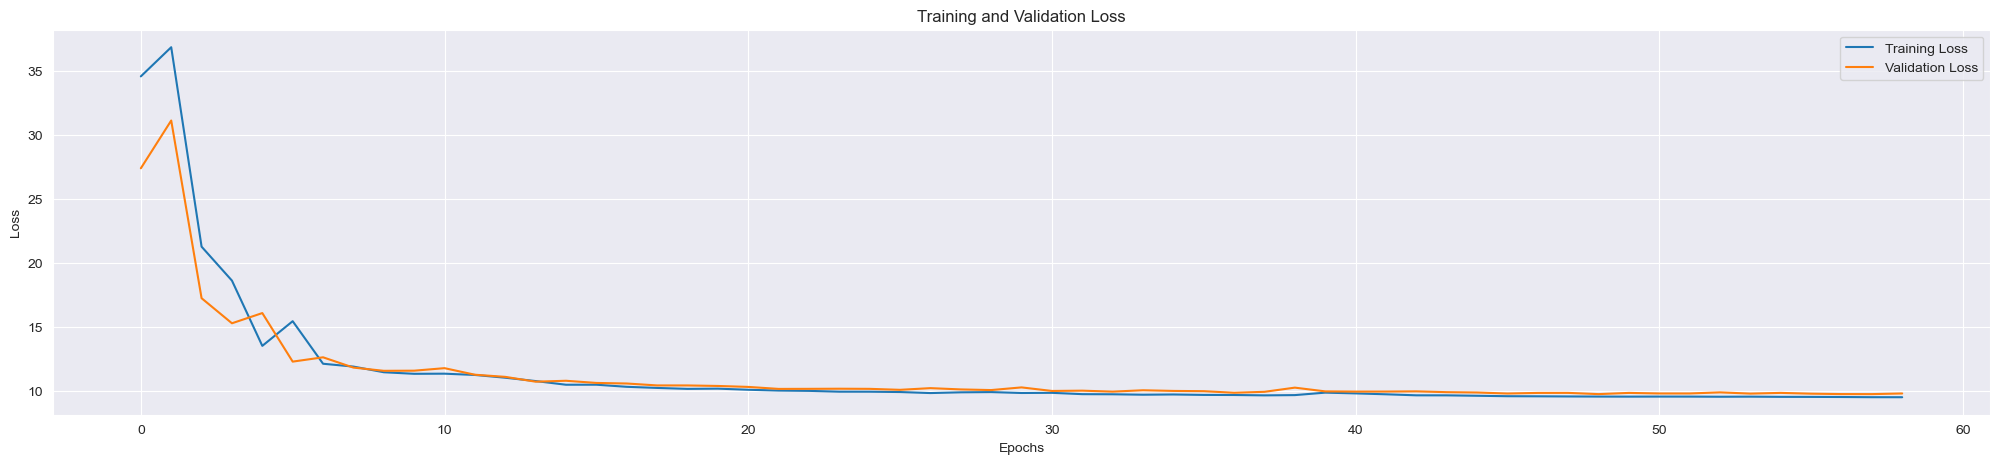

In [74]:
def plot_losses(history):
    train_losses = history['history_train']
    val_losses = history['history_val']

    plt.figure(figsize=(25, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_losses(result)

In [75]:
print("Model Huber Loss on Train:", result['train_loss'])
print("Model MAPE on Train:", result['train_mape'])
print("Model Huber Loss on Test:", result['test_loss'])
print("Model MAPE on Test:", result['test_mape'])

Model Huber Loss on Train: 9.498
Model MAPE on Train: 23.6451
Model Huber Loss on Test: 9.563
Model MAPE on Test: 23.4523


**Observation**
- Although observed MAPE was 23.4, according to the plot, we can say it will vary a lot on different datasets.
- We can say that we'll get a MAPE of 25 in general conditions.
- Model is a Best Fit for given conditions.

### Comparison with Classical Models

Using classical models to predict this, can help us identify and compare out neural network results. Since this is a regression problem, we can use various types of regressors like
- Linear Regression
- Random Forest
- Gradient Boost

In our analysis we are going to implement Gradient Boost

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(n_estimators=128, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)
gbr_predictions = gbr_model.predict(X_val)
gbr_mape = mean_absolute_percentage_error(y_val, gbr_predictions)
gbr_r2 = r2_score(y_val, gbr_predictions)
print(f'Gradient Boosting Regressor MAPE: {gbr_mape:.2f}')

Gradient Boosting Regressor MAPE: 0.25


**Observation**

- Classical models outperforms neural networks in case of predictions.
- Even a simple model as above was able to train faster and results in more consistent states when compared to neural network.
- We might need to extensively work on feature engineering to capture more intriguing patterns for our network tp register.

### Neural Network Performance on Large Datasets

Neural networks generally outperforms classical models on large dataset because of its capacity to derive complex patterns which a classical model fails to achieve in same complexity step efficiently. With more data network can generalize and form complex features while providing sufficient examples to avoid overfitting.

Considering our experiment, we can say that our data had low underlying non linear patterns and no relevant features could be synthesized by our network. This indicates that our data may have some patterns, but is largely influenced by noise as well.

### Model Explanation using Lime

In [77]:
def predict_fn(input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        predictions =  model(input_tensor).squeeze().cpu().detach().numpy()
    return predictions

Actual Value: 103.0
Predicted Value: 62.29178


<Figure size 2500x500 with 0 Axes>

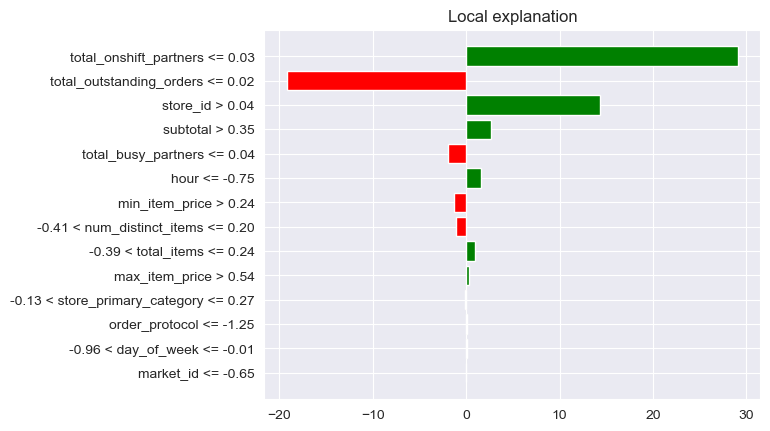

In [78]:
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                                   feature_names=X_train.columns.to_list(),
                                                   discretize_continuous=True,
                                                   mode='regression')

n = 7470
instance = X_test.iloc[n].to_numpy()
explanation = explainer.explain_instance(instance, predict_fn, num_features=14)

print("Actual Value:", y_test.iloc[n])
print("Predicted Value:", predict_fn([instance]))

plt.figure(figsize=(25,5))
explanation.as_pyplot_figure()
plt.show()

Actual Value: 41.0
Predicted Value: 57.110123


<Figure size 2500x500 with 0 Axes>

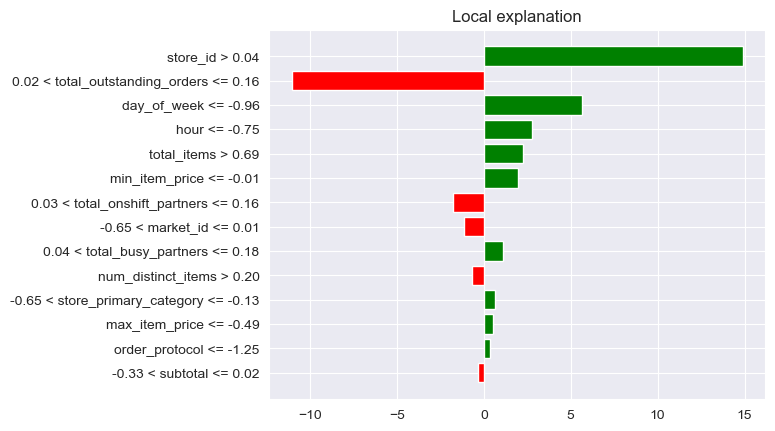

In [79]:
n = 3454
instance = X_test.iloc[n].to_numpy()
explanation = explainer.explain_instance(instance, predict_fn, num_features=14)

print("Actual Value:", y_test.iloc[n])
print("Predicted Value:", predict_fn([instance]))

plt.figure(figsize=(25,5))
explanation.as_pyplot_figure()
plt.show()

Actual Value: 55.0
Predicted Value: 54.454456


<Figure size 2500x500 with 0 Axes>

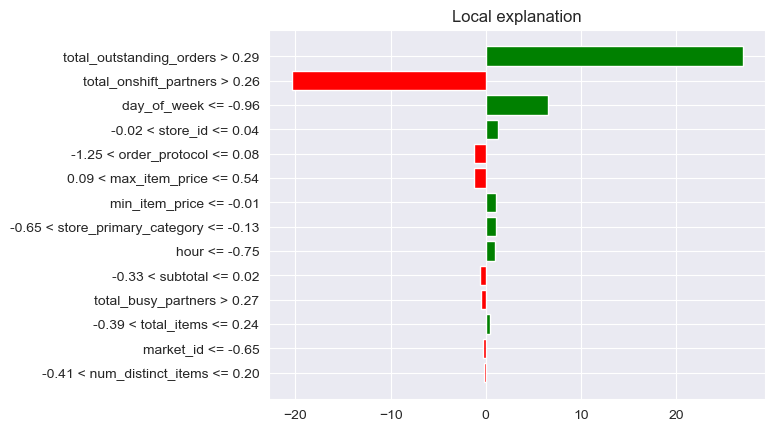

In [80]:
n = 4354
instance = X_test.iloc[n].to_numpy()
explanation = explainer.explain_instance(instance, predict_fn, num_features=14)

print("Actual Value:", y_test.iloc[n])
print("Predicted Value:", predict_fn([instance]))

plt.figure(figsize=(25,5))
explanation.as_pyplot_figure()
plt.show()

**Observation**
- The most important factors for delivery are
    - Availability of partners
    - Total outstanding orders.
    - Order Monetary Value

# Insights & Recommendations

### Technical Insights

- Observed Negative Values in `item_price`, indicating logging error or a wave off to customer due to logistic issue.
- Negative values in `onshift`, `busy` and `outstanding_ordrers` might indicate extreme end of the minimum business threshold set for each, indicating availability in excess or less.
- Most orders are placed from `market_id` 2 & 4
- Common `order_protocol` used to place orders are 1 & 3.
- Most of the Continuous Distributions are Log Normal in Nature
- Customers generally place orders having 1-3 distinct items.
- Not all stores operate for `order_protocal` 7, and those who are operate are from `market_id` 2 & 4, where orders originating from `market_id` 2 takes high time to deliver.
- Stores with average `eta` of 300 minutes needs to be inspected thoroughly.
- Order placed during afternoon takes most time to deliver.
- `eta` is affected due to the high `total_outstaning_orders`.
- `Comfort Food` takes more time to deliver.
- High correlation observed between partners and outstanding orders.
- Outliers observed in `subtotal`, `item_price` and `total_items`. These features generally follow Log Normal Distributions.
- Our Neural Network model shows a MAPE of 23.6, when compared with classical models, the difference observed is not significant enough. This indicates.
    - Need for more Data, Features (No relevant features synthesized from existing features) to improve model performance.
    - This also indicates that although delivery estimates have some patterns, but is also significantly influenced by external factors.
- Most important factors for delivery are partners availability, total outstanding orders, time and cart value.


### Recommendation

- Allocate proper reinforcements for high volume market such as markets with id 1 & 2
- Since a customer generally places an order for 1-3 distinct items, try to optimize delivery process by making the personnel deliver multiple places in 1 go.
- Inspection needs to be made with stores with higher average eta than global.
- Since during afternoon most orders are placed, try to create a dedicated task force for that period, ensuring a balanced delivery partners distribution to meet fluctuating demands.
- Develop smarter algorithm to assign delivery partners as efficiently as possible.
- Inspect why order placed through protocol 7 takes more time to deliver and the popularity in order protocols 1 & 3.
- To improve model performance, try to collect more data and identify additional external factors.

---